<a href="https://colab.research.google.com/github/sofiageraldine10-ai/An-lisisprospectivo-de-la-mortalidad-ECV-y-TEMP/blob/main/Proyecto_Grado_SGVC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Instalación y librerías

In [37]:
!pip -q install pandas numpy statsmodels patsy matplotlib openpyxl unidecode

import os, io, re, shutil, warnings
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import statsmodels.api as sm
from patsy import dmatrix, build_design_matrices
from unidecode import unidecode

warnings.filterwarnings("ignore")
np.random.seed(42)

RESULTS_DIR = "resultados_objetivo1"
os.makedirs(RESULTS_DIR, exist_ok=True)


# 2) Subida de archivos (POWER + Mortalidad)


* 4 CSV de NASA POWER con T2M_MAX/T2M_MIN (uno por



ciudad: Bogotá, Medellín, Cali, Barranquilla).
(Normalmente en el nombre aparece “MAX Y MIN”).

Mortalidad diaria (CSV o Excel) con columnas tipo: Año, Mes, Dia, Departamento, Municipio, y TOTAL Ixx-Iyy (capítulos CIE-10 cardiovasculares).

In [38]:
from google.colab import files
uploaded = files.upload()
list(uploaded.keys())


Saving Base_diaria_MORT (1).xlsx to Base_diaria_MORT (1) (2).xlsx
Saving POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST CALI.csv to POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST CALI (2).csv
Saving POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST MAX Y MIN CALI.csv to POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST MAX Y MIN CALI (2).csv
Saving POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST (1) MAX Y MIN BOGOTÁ.csv to POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST (1) MAX Y MIN BOGOTÁ (2).csv
Saving POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST BOGOTA.csv to POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST BOGOTA (2).csv
Saving POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MAX Y MIN MEDELLIN.csv to POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MAX Y MIN MEDELLIN (2).csv
Saving POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MEDELLIN.csv to POWER_Point_Daily_20100101_20201231_006d25N_075d58W

['Base_diaria_MORT (1) (2).xlsx',
 'POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST CALI (2).csv',
 'POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST MAX Y MIN CALI (2).csv',
 'POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST (1) MAX Y MIN BOGOTÁ (2).csv',
 'POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST BOGOTA (2).csv',
 'POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MAX Y MIN MEDELLIN (2).csv',
 'POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MEDELLIN (2).csv',
 'POWER_Point_Daily_20100101_20201231_010d96N_074d80W_LST BARRANQUILLA (2).csv',
 'POWER_Point_Daily_20100101_20201231_010d96N_074d80W_LST MAX Y MIN BARRANQUILLA (2).csv']

#3) Utilidades para leer POWER (MAX/MIN) y construir temperaturas

* Salta metadatos de POWER (-END HEADER-).

* Construye fecha desde YEAR + DOY.

* Valida que existan T2M_MAX y T2M_MIN.

* Infiero ciudad desde el nombre del archivo.

In [39]:
def _is_power_maxmin_csv(fname:str, content:bytes) -> bool:
    txt = content.decode("utf-8", errors="ignore").lower()
    return ("t2m_max" in txt and "t2m_min" in txt)

def read_power_maxmin_from_bytes(fname:str, content:bytes) -> pd.DataFrame:
    lines = content.decode("utf-8", errors="ignore").splitlines()
    skip = 0
    for i, line in enumerate(lines[:120]):
        if line.strip().startswith("-END HEADER-"):
            skip = i + 1
            break
    df = pd.read_csv(io.BytesIO(content), skiprows=skip)

    if {"YEAR","DOY"}.issubset(df.columns):
        def yday_to_date(y, d):
            try:
                return pd.Timestamp(dt.datetime(int(y), 1, 1) + dt.timedelta(days=int(d)-1))
            except Exception:
                return pd.NaT
        df["date"] = [yday_to_date(y, d) for y, d in zip(df["YEAR"], df["DOY"])]
    elif "DATE" in df.columns:
        df["date"] = pd.to_datetime(df["DATE"], errors="coerce", format="%Y%m%d")
    else:
        raise ValueError(f"{fname}: no hallé YEAR/DOY ni DATE.")

    col_max = [c for c in df.columns if "T2M_MAX" in c.upper() or "LST_MAX" in c.upper() or "TMAX" in c.upper()]
    col_min = [c for c in df.columns if "T2M_MIN" in c.upper() or "LST_MIN" in c.upper() or "TMIN" in c.upper()]
    if not col_max or not col_min:
        raise ValueError(f"{fname}: faltan columnas MAX/MIN.")

    df = df.rename(columns={col_max[0]:"tmax", col_min[0]:"tmin"})
    df = df[["date","tmax","tmin"]].copy()
    for c in ["tmax","tmin"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df[(df["date"]>=pd.Timestamp("2010-01-01")) & (df["date"]<=pd.Timestamp("2019-12-31"))]

    base = unidecode(os.path.basename(fname)).lower()
    if "bogota" in base:
        city = "Bogotá"
    elif "medellin" in base:
        city = "Medellín"
    elif "cali" in base:
        city = "Cali"
    elif "barranquilla" in base:
        city = "Barranquilla"
    else:
        raise ValueError(f"No pude inferir ciudad desde el nombre: {fname}")
    df["city"] = city
    return df.sort_values("date").reset_index(drop=True)

def load_all_power(uploaded:dict) -> pd.DataFrame:
    dfs = []
    for fname, content in uploaded.items():
        if fname.lower().endswith(".csv") and _is_power_maxmin_csv(fname, content):
            try:
                dfs.append(read_power_maxmin_from_bytes(fname, content))
            except Exception as e:
                print(f"[POWER] Saltando {fname} → {e}")
    if not dfs:
        raise RuntimeError("No encontré CSV POWER con T2M_MAX/T2M_MIN (archivos 'MAX Y MIN').")
    temp = pd.concat(dfs, ignore_index=True)
    return temp.sort_values(["city","date"]).reset_index(drop=True)


#4) Construir dataset de temperaturas + umbrales + exposición

* Umbrales por ciudad: P95 de tmax (calor) y P05 de tmin (frío).

* Banderas diarias heat_extreme y cold_extreme.

* Resumen de exposición.

In [40]:
temps = load_all_power(uploaded)

thr = temps.groupby("city").agg(
    tmax_p95=("tmax", lambda s: float(np.nanpercentile(s, 95))),
    tmin_p05=("tmin", lambda s: float(np.nanpercentile(s, 5))),
).reset_index()

temps = temps.merge(thr, on="city", how="left")
temps["heat_extreme"] = (temps["tmax"] >= temps["tmax_p95"]).astype(int)
temps["cold_extreme"] = (temps["tmin"] <= temps["tmin_p05"]).astype(int)

expo = temps.groupby("city").agg(
    umbral_calor=("tmax_p95","first"),
    umbral_frio=("tmin_p05","first"),
    dias_calor=("heat_extreme","sum"),
    dias_frio=("cold_extreme","sum"),
).reset_index()

display(expo)

temps.to_csv(os.path.join(RESULTS_DIR, "temperaturas_2010_2019_con_extremos.csv"), index=False)



,city,umbral_calor,umbral_frio,dias_calor,dias_frio
0,Barranquilla,32.3600,24.3855,184,183
1,Bogotá,26.6845,12.2600,183,185
2,Cali,23.9445,10.5400,183,185
3,Medellín,23.0200,11.8400,185,187


#5) Utilidades para mortalidad (formato ancho por capítulos CIE-10)

* Construye date desde Año + Mes + Dia (mes puede venir como texto: “enero”, “ene”, etc.).

* Mapea Municipio → city (Bogotá, Medellín, Cali, Barranquilla).

* Suma cardiovasculares: TOTAL I10-I15, I20-I25, I26-I28, I30-I52, I60-I69, I70-I79.

* Devuelve largo: date, city, cvd_deaths (agregado por día y ciudad).

In [41]:
def _norm(s): return unidecode(str(s)).strip().lower()

_HEADER_TOKENS = {
    "fecha","date","año","ano","year","mes","month","mo","dia","día","day",
    "municipio","ciudad","mpio","mun",
    "total i10-i15","total i20-i25","total i26-i28","total i30-i52","total i60-i69","total i70-i79",
    "total general"
}

def _find_header_row(df0: pd.DataFrame, max_scan: int = 40) -> int:
    for i in range(min(max_scan, len(df0))):
        row = df0.iloc[i].astype(str).fillna("").tolist()
        toks = {_norm(x) for x in row if x and x != "nan"}
        hits = sum(1 for t in toks for k in _HEADER_TOKENS if k in t)
        non_empty = sum(1 for x in row if x and x != "nan")
        if hits >= 2 or (hits >= 1 and non_empty >= 4):
            return i
    return 0

def _read_csv_guess_header(content: bytes) -> pd.DataFrame:
    df0 = pd.read_csv(io.BytesIO(content), header=None, sep=None, engine="python")
    h = _find_header_row(df0)
    cols = df0.iloc[h].astype(str).tolist()
    df = df0.iloc[h+1:].copy()
    df.columns = cols
    df = df.loc[:, ~df.columns.astype(str).str.fullmatch(r"\s*")]
    return df.reset_index(drop=True)

def _read_excel_guess_header(content: bytes) -> pd.DataFrame:
    df0 = pd.read_excel(io.BytesIO(content), header=None, engine="openpyxl")
    h = _find_header_row(df0)
    df  = pd.read_excel(io.BytesIO(content), header=h, engine="openpyxl")
    empty_cols = [c for c in df.columns if df[c].isna().all()]
    if empty_cols:
        df = df.drop(columns=empty_cols)
    return df.reset_index(drop=True)

def smart_read_table(uploaded: dict, prefer_keys=("mort","mortal","defunc","base_diaria_mort")) -> pd.DataFrame:
    keys = list(uploaded.keys())
    cand = [k for k in keys if any(pk in unidecode(k.lower()) for pk in prefer_keys)]
    fname = cand[0] if cand else keys[-1]
    content = uploaded[fname]
    if fname.lower().endswith(".csv"):
        df = _read_csv_guess_header(content)
    elif fname.lower().endswith((".xlsx",".xls")):
        df = _read_excel_guess_header(content)
    else:
        raise ValueError(f"Formato no soportado: {fname}")
    print(f"[SMART READ] Archivo: {fname}")
    print(f"[SMART READ] Columnas detectadas: {list(df.columns)[:12]}{' ...' if df.shape[1]>12 else ''}")
    return df

_MONTH_MAP = {
    "enero":1,"ene":1,"febrero":2,"feb":2,"marzo":3,"mar":3,"abril":4,"abr":4,
    "mayo":5,"may":5,"junio":6,"jun":6,"julio":7,"jul":7,"agosto":8,"ago":8,
    "septiembre":9,"setiembre":9,"sep":9,"set":9,"octubre":10,"oct":10,
    "noviembre":11,"nov":11,"diciembre":12,"dic":12,
    "january":1,"jan":1,"february":2,"feb":2,"march":3,"mar":3,"april":4,"apr":4,
    "may":5,"june":6,"jun":6,"july":7,"jul":7,"august":8,"aug":8,"september":9,"sep":9,
    "october":10,"oct":10,"november":11,"nov":11,"december":12,"dec":12
}

def _extract_year_series(s: pd.Series) -> pd.Series:
    s = s.astype(str)
    y = pd.to_numeric(s, errors="coerce")
    bad = y.isna()
    if bad.any():
        y2 = s.str.extract(r"(\d{4})", expand=False)
        y.loc[bad] = pd.to_numeric(y2.loc[bad], errors="coerce")
    y = y.where((y>=1900) & (y<=2100))
    return y

def _extract_month_series(s: pd.Series) -> pd.Series:
    s0 = s.astype(str)
    m = pd.to_numeric(s0, errors="coerce")
    need = m.isna()
    if need.any():
        s_norm = s0.str.lower().apply(unidecode)
        def map_month(txt):
            tokens = re.findall(r"[a-z]+|\d+", txt)
            for t in tokens:
                if t in _MONTH_MAP: return _MONTH_MAP[t]
            for t in tokens:
                if t.isdigit():
                    v = int(t)
                    if 1 <= v <= 12: return v
            return np.nan
        m.loc[need] = [map_month(t) for t in s_norm[need]]
    return pd.to_numeric(m, errors="coerce")

def _extract_day_series(s: pd.Series) -> pd.Series:
    if s is None: return None
    s0 = s.astype(str)
    d = pd.to_numeric(s0, errors="coerce")
    need = d.isna()
    if need.any():
        d2 = s0.str.extract(r"(\d{1,2})", expand=False)
        d.loc[need] = pd.to_numeric(d2.loc[need], errors="coerce")
    d = d.where((d>=1) & (d<=31))
    return d

def build_date_column(df: pd.DataFrame) -> pd.DataFrame:
    cols = {_norm(c): c for c in df.columns}
    ycol = next((cols[k] for k in ["año","ano","year"] if k in cols), None)
    mcol = next((cols[k] for k in ["mes","month","mo"] if k in cols), None)
    dcol = next((cols[k] for k in ["dia","día","day","dy","d"] if k in cols), None)

    if ycol and mcol:
        y = _extract_year_series(df[ycol])
        m = _extract_month_series(df[mcol])
        d = _extract_day_series(df[dcol]) if dcol else pd.Series(1, index=df.index)
        d = d.fillna(1)
        dt_ = pd.to_datetime(pd.DataFrame({"year": y, "month": m, "day": d}), errors="coerce")
        if dt_.notna().sum() > 0:
            out = df.copy()
            out["date"] = dt_
            out = out[out["date"].notna()].reset_index(drop=True)
            print(f"[DATE] Construida 'date' desde Año/Mes/Dia. Filas válidas: {len(out)}")
            return out

    for k in ["fecha","date","fecha_def","fechadef","fecha_ocurrencia","fechaocurrencia"]:
        if k in cols:
            out = df.rename(columns={cols[k]:"date"}).copy()
            out["date"] = pd.to_datetime(out["date"], errors="coerce")
            out = out[out["date"].notna()].reset_index(drop=True)
            if not out.empty:
                print(f"[DATE] Usando columna existente '{cols[k]}'. Filas válidas: {len(out)}")
                return out

    raise ValueError("No encontré 'Año/Mes/Dia' ni 'fecha/date' válidos para construir la columna 'date'.")

def map_city_from_municipio(mun: str):
    s = _norm(mun)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    if "bogota" in s: return "Bogotá"
    if "medellin" in s: return "Medellín"
    if "santiago de cali" in s or s == "cali" or s.endswith(" cali"): return "Cali"
    if "barranquilla" in s: return "Barranquilla"
    return None

def sum_cvd_columns(df: pd.DataFrame):
    pats = [
        r"^total\s*i10\s*-\s*i15$",
        r"^total\s*i20\s*-\s*i25$",
        r"^total\s*i26\s*-\s*i28$",
        r"^total\s*i30\s*-\s*i52$",
        r"^total\s*i60\s*-\s*i69$",
        r"^total\s*i70\s*-\s*i79$",
    ]
    norm_map = {_norm(c): c for c in df.columns}
    used = []
    for pat in pats:
        for nk, orig in norm_map.items():
            if re.fullmatch(pat, nk):
                used.append(orig); break
    if not used:
        raise ValueError("No encontré columnas 'TOTAL I..-I..' cardiovasculares.")
    cvd = df[used].apply(pd.to_numeric, errors="coerce").sum(axis=1)
    return cvd, used

def load_mortality(uploaded: dict) -> pd.DataFrame:
    mort_raw = smart_read_table(uploaded)
    mort_raw = build_date_column(mort_raw)

    if "Municipio" not in mort_raw.columns:
        alt = next((c for c in mort_raw.columns if _norm(c) in ["municipio","ciudad","mpio","mun"]), None)
        if alt is None:
            raise ValueError("No encontré columna 'Municipio' (o equivalente).")
        mort_raw = mort_raw.rename(columns={alt: "Municipio"})
    mort_raw["city"] = mort_raw["Municipio"].astype(str).map(map_city_from_municipio)
    mort_raw = mort_raw[mort_raw["city"].isin(["Bogotá","Medellín","Cali","Barranquilla"])].copy()
    if mort_raw.empty:
        raise ValueError("Tras mapear municipios no quedaron filas para las 4 ciudades.")

    mort_raw["cvd_deaths"], used_cols = sum_cvd_columns(mort_raw)

    mort_long = (mort_raw.groupby(["date","city"], as_index=False)["cvd_deaths"]
                         .sum()
                         .sort_values(["city","date"])
                         .reset_index(drop=True))
    print("[INFO] Columnas CV usadas:", used_cols)
    print("[INFO] Mortalidad agregada — filas:", len(mort_long),
          "| rango:", mort_long["date"].min(), "→", mort_long["date"].max(),
          "| ciudades:", mort_long["city"].unique().tolist())
    return mort_long


#6) Cargar mortalidad, unir con temperaturas y crear covariables

In [42]:
mort_long = load_mortality(uploaded)

df = temps.merge(mort_long, on=["date","city"], how="inner").copy()
df = df.sort_values(["city","date"]).reset_index(drop=True)

df["dow"]   = df["date"].dt.dayofweek.astype("category")
df["month"] = df["date"].dt.month.astype("category")
df["trend"] = (df["date"] - df["date"].min()).dt.days

display(df.head())



[SMART READ] Archivo: Base_diaria_MORT (1) (2).xlsx
[SMART READ] Columnas detectadas: ['Año', 'Mes', 'Dia', 'Departamento', 'Municipio', 'POBLACIÓN', 'FEMENINO', 'MASCULINO', 'TOTAL I10-I15', 'FEMENINO.1', 'INDETERMINADO', 'MASCULINO.1'] ...
[DATE] Construida 'date' desde Año/Mes/Dia. Filas válidas: 105069
[INFO] Columnas CV usadas: ['TOTAL I10-I15', 'TOTAL I20-I25', 'TOTAL I26-I28', 'TOTAL I30-I52', 'TOTAL I60-I69', 'TOTAL I70-I79']
[INFO] Mortalidad agregada — filas: 387 | rango: 2010-01-20 00:00:00 → 2019-12-20 00:00:00 | ciudades: ['Barranquilla', 'Bogotá', 'Cali', 'Medellín']


,date,tmax,tmin,city,tmax_p95,tmin_p05,heat_extreme,cold_extreme,cvd_deaths,dow,month,trend
0,2010-01-20,31.65,24.84,Barranquilla,32.36,24.3855,0,0,39,2,1,0
1,2010-02-20,32.13,25.90,Barranquilla,32.36,24.3855,0,0,53,5,2,31
2,2010-03-20,31.60,26.83,Barranquilla,32.36,24.3855,0,0,44,5,3,59
3,2010-04-20,29.61,26.83,Barranquilla,32.36,24.3855,0,0,29,1,4,90
4,2010-05-20,29.96,26.69,Barranquilla,32.36,24.3855,0,0,36,3,5,120


#7) Funciones de modelado (GLM Poisson + splines) y RR con IC95%

* Splines B (df=4) para Tmax y Tmin.

* Control por dow, mes, tendencia.

* SE robustas (HC0).

* RR por simulación MVN(β, Σ).

In [43]:
# --- construir bloques spline y guardar su meta (nudos + renombres) ---
def _make_spline_block(x: pd.Series, base_prefix: str, df_target: int):
    x = pd.to_numeric(x, errors="coerce")
    if df_target >= 2:
        raw = dmatrix(f"bs(x, df={df_target}, include_intercept=False)",
                      {"x": x}, return_type="dataframe")
        rename_map = {old: f"{base_prefix}{i+1}" for i, old in enumerate(raw.columns)}
        block = raw.copy(); block.columns = [rename_map[c] for c in raw.columns]
        return block, raw.design_info, rename_map
    else:
        block = pd.DataFrame({f"{base_prefix}lin": x})
        return block, None, None

def _drop_constant_and_duplicate_cols(X: pd.DataFrame):
    keep = []
    for c in X.columns:
        col = pd.to_numeric(X[c], errors="coerce")
        if col.notna().sum() == 0: continue
        if np.nanstd(col.values) == 0: continue
        keep.append(c)
    X = X[keep].copy()
    if X.shape[1] > 1:
        hashes, keep2 = {}, []
        for c in X.columns:
            h = pd.util.hash_pandas_object(X[c].round(12), index=False).sum()
            if h in hashes and np.array_equal(np.nan_to_num(X[c].values),
                                              np.nan_to_num(X[hashes[h]].values)):
                continue
            hashes[h] = c; keep2.append(c)
        X = X[keep2].copy()
    return X

def _design_with_meta(g: pd.DataFrame, df_tmax=4, df_tmin=4, include_month=True):
    smax, di_max, map_max = _make_spline_block(g["tmax"], "s_tmax_", df_tmax)
    smin, di_min, map_min = _make_spline_block(g["tmin"], "s_tmin_", df_tmin)

    d_dow   = pd.get_dummies(g["dow"].astype("category"),   prefix="dow", drop_first=True)
    d_month = pd.get_dummies(g["month"].astype("category"), prefix="m",   drop_first=True) if include_month else pd.DataFrame(index=g.index)

    X = pd.concat([smax, smin, d_dow, d_month, g[["trend"]]], axis=1)
    X = X.apply(pd.to_numeric, errors="coerce").astype(float)
    X = _drop_constant_and_duplicate_cols(X)
    X = sm.add_constant(X, has_constant="add")

    meta = {
        "tmax_design_info": di_max,
        "tmin_design_info": di_min,
        "tmax_rename_map": map_max,
        "tmin_rename_map": map_min,
        "tmax_cols": [c for c in X.columns if str(c).startswith("s_tmax_")],
        "tmin_cols": [c for c in X.columns if str(c).startswith("s_tmin_")],
        "template_cols": list(X.columns),
        "include_month": include_month,
    }
    return X, meta

def _drop_invalid_rows(X: pd.DataFrame, y: pd.Series):
    mask = np.isfinite(X.values).all(axis=1) & np.isfinite(y.values)
    X2, y2 = X.loc[mask].copy(), y.loc[mask].copy()
    bad = X2.isna().any(axis=1) | y2.isna()
    if bad.any():
        X2, y2 = X2.loc[~bad].copy(), y2.loc[~bad].copy()
    return X2, y2

def fit_city_poisson(g: pd.DataFrame):
    """
    Reintentos: incluye/quita mes y baja df de splines.
    Devuelve: res, Xc, dispersion, meta
    """
    y = pd.to_numeric(g["cvd_deaths"], errors="coerce").astype(float)
    MIN_OBS = 20

    for include_month in (True, False):
        for df_try in [(4,4),(3,3),(2,2),(1,1)]:
            X, meta = _design_with_meta(g, df_tmax=df_try[0], df_tmin=df_try[1], include_month=include_month)
            Xc, yc = _drop_invalid_rows(X, y)
            if len(yc) < MIN_OBS or Xc.shape[1] >= len(yc) - 2:
                continue
            try:
                model = sm.GLM(yc.values, Xc.values, family=sm.families.Poisson())
                res = model.fit(cov_type="HC0")
                pearson = res.resid_pearson
                dispersion = float((pearson**2).sum() / res.df_resid)
                Xc.columns = X.columns
                meta["template_cols"] = list(Xc.columns)
                meta["df_tmax_used"] = sum(1 for c in Xc.columns if str(c).startswith("s_tmax_"))
                meta["df_tmin_used"] = sum(1 for c in Xc.columns if str(c).startswith("s_tmin_"))
                return res, Xc, dispersion, meta
            except np.linalg.LinAlgError:
                continue
            except Exception:
                continue

    raise ValueError("No fue posible ajustar el modelo: datos insuficientes o colinealidad persistente.")

def make_Xnew_from_meta(meta: dict, tmax_val: float, tmin_val: float, trend_ref: float):
    parts = []
    # Tmax
    if any(c == "s_tmax_lin" for c in meta["tmax_cols"]):
        parts.append(pd.DataFrame({"s_tmax_lin":[tmax_val]}))
    elif meta["tmax_cols"]:
        M = build_design_matrices([meta["tmax_design_info"]], {"x":[tmax_val]})[0]
        dfM = pd.DataFrame(M, columns=meta["tmax_design_info"].column_names)
        dfM = dfM.rename(columns=meta["tmax_rename_map"])
        dfM = dfM.reindex(columns=meta["tmax_cols"], fill_value=0.0)
        parts.append(dfM)
    else:
        parts.append(pd.DataFrame(index=[0]))
    # Tmin
    if any(c == "s_tmin_lin" for c in meta["tmin_cols"]):
        parts.append(pd.DataFrame({"s_tmin_lin":[tmin_val]}))
    elif meta["tmin_cols"]:
        M = build_design_matrices([meta["tmin_design_info"]], {"x":[tmin_val]})[0]
        dfM = pd.DataFrame(M, columns=meta["tmin_design_info"].column_names)
        dfM = dfM.rename(columns=meta["tmin_rename_map"])
        dfM = dfM.reindex(columns=meta["tmin_cols"], fill_value=0.0)
        parts.append(dfM)
    else:
        parts.append(pd.DataFrame(index=[0]))

    Xnew = pd.concat(parts + [pd.DataFrame({"trend":[trend_ref]})], axis=1)
    Xnew = sm.add_constant(Xnew, has_constant="add")

    for c in meta["template_cols"]:
        if c not in Xnew.columns:
            Xnew[c] = 0.0
    return Xnew[meta["template_cols"]]

def rr_with_ci(res, X_cols, g: pd.DataFrame, meta: dict, draws:int=2000):
    tmax_p50 = float(np.nanmedian(g["tmax"]))
    tmin_p50 = float(np.nanmedian(g["tmin"]))
    tmax_p95 = float(np.nanpercentile(g["tmax"], 95))
    tmin_p05 = float(np.nanpercentile(g["tmin"], 5))
    trend_ref = float(np.nanmedian(g["trend"]))

    X_ref  = make_Xnew_from_meta(meta, tmax_p50, tmin_p50, trend_ref).values
    X_hot  = make_Xnew_from_meta(meta, tmax_p95, tmin_p50, trend_ref).values
    X_cold = make_Xnew_from_meta(meta, tmax_p50, tmin_p05, trend_ref).values

    beta = np.asarray(res.params)
    cov  = np.asarray(res.cov_params())
    betas = np.random.multivariate_normal(beta, cov, size=draws)

    mu_ref  = np.exp(X_ref  @ betas.T).ravel()
    mu_hot  = np.exp(X_hot  @ betas.T).ravel()
    mu_cold = np.exp(X_cold @ betas.T).ravel()

    def summ(v):
        return float(np.median(v)), float(np.percentile(v,2.5)), float(np.percentile(v,97.5))

    rrh, rrh_lo, rrh_hi = summ(mu_hot / mu_ref)
    rrc, rrc_lo, rrc_hi = summ(mu_cold / mu_ref)
    return {
        "RR_calor": rrh, "RR_calor_IC95_lo": rrh_lo, "RR_calor_IC95_hi": rrh_hi,
        "RR_frio":  rrc, "RR_frio_IC95_lo":  rrc_lo, "RR_frio_IC95_hi":  rrc_hi,
        "tmax_p50": tmax_p50, "tmin_p50": tmin_p50, "tmax_p95": tmax_p95, "tmin_p05": tmin_p05
    }

def plot_risk_curve(g: pd.DataFrame, res, meta: dict, var="tmax", fname="curva.png"):
    other = float(np.nanmedian(g["tmin" if var=="tmax" else "tmax"]))
    grid  = np.linspace(np.nanpercentile(g[var], 1), np.nanpercentile(g[var], 99), 80)
    beta  = np.asarray(res.params).reshape(-1,1)
    trend_ref = float(np.nanmedian(g["trend"]))

    X_ref = make_Xnew_from_meta(meta, float(np.nanmedian(g["tmax"])),
                                     float(np.nanmedian(g["tmin"])), trend_ref)
    mu_ref = float(np.exp(X_ref.values @ beta))

    preds_rr = []
    for v in grid:
        if var=="tmax":
            Xn = make_Xnew_from_meta(meta, v, other, trend_ref)
        else:
            Xn = make_Xnew_from_meta(meta, other, v, trend_ref)
        mu = float(np.exp(Xn.values @ beta))
        preds_rr.append(mu / mu_ref)

    plt.figure(figsize=(6.2,4.2))
    plt.plot(grid, preds_rr)
    plt.xlabel(f"{'Tmax' if var=='tmax' else 'Tmin'} (°C)")
    plt.ylabel("Riesgo relativo (vs P50)")
    plt.title(f"Curva de riesgo ({'Tmax' if var=='tmax' else 'Tmin'}) - {g['city'].iat[0]}")
    plt.tight_layout()
    os.makedirs(RESULTS_DIR, exist_ok=True)
    plt.savefig(os.path.join(RESULTS_DIR, fname), dpi=140)
    plt.close()


#8) Ajuste por ciudad, RR + curvas, y exportes

* Ajusta GLM Poisson por ciudad.

* Calcula RR calor y RR frío con IC95%.

* Guarda CSV de resultados y PNG de curvas.



[Barranquilla] GLM Poisson (SE robusta) | dispersión ~ 1.11 | df spline: Tmax=4, Tmin=4
[Bogotá] df=2 is too small for degree=3 and include_intercept=False; must be >= 3. Se omite.
[Cali] GLM Poisson (SE robusta) | dispersión ~ 1.47 | df spline: Tmax=4, Tmin=4
[Medellín] GLM Poisson (SE robusta) | dispersión ~ 1.84 | df spline: Tmax=4, Tmin=4


,Ciudad,Umbral_calor_P95_Tmax,Umbral_frio_P05_Tmin,RR_calor,RR_calor_IC95_lo,RR_calor_IC95_hi,RR_frio,RR_frio_IC95_lo,RR_frio_IC95_hi,Dispersion_Poisson,df_spline_Tmax,df_spline_Tmin
0,Barranquilla,32.19,24.38,0.955,0.887,1.026,1.008,0.897,1.137,1.11,4,4
1,Cali,24.54,10.54,0.896,0.813,0.985,0.936,0.860,1.019,1.47,4,4
2,Medellín,23.02,11.72,1.036,0.936,1.145,0.976,0.909,1.050,1.84,4,4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
# ===== 8B.1 — AJUSTE NEGATIVE BINOMIAL (NB) + UTILIDADES =====
import numpy as np, pandas as pd, statsmodels.api as sm
import matplotlib.pyplot as plt, os

def _fit_nb_from_alpha(yc, Xc, alpha, cov_type="HC0"):
    """Ajusta GLM NB2 con alpha fijo y devuelve resultado o None si falla."""
    try:
        fam = sm.families.NegativeBinomial(alpha=alpha)
        mod = sm.GLM(yc, Xc, family=fam)
        res = mod.fit(cov_type=cov_type)
        return res
    except Exception:
        return None

def fit_city_negbin(g: pd.DataFrame, min_obs=20):
    """
    Igual que fit_city_poisson, pero devuelve un ajuste GLM NB2.
    - Estima alpha a partir de la dispersión Poisson (phi-1) y prueba un pequeño grid.
    Devuelve: res_nb, Xc, dispersion_nb, meta, alpha_usado
    """
    y = pd.to_numeric(g["cvd_deaths"], errors="coerce").astype(float)

    best = None  # (crit, res_nb, Xc, dispersion, meta, alpha)

    for include_month in (True, False):
        for df_try in [(4,4), (3,3), (2,2), (1,1)]:
            # 1) Diseño con meta
            X, meta = _design_with_meta(g, df_tmax=df_try[0], df_tmin=df_try[1], include_month=include_month)
            Xc, yc = _drop_invalid_rows(X.values, y.values) if isinstance(X, np.ndarray) else _drop_invalid_rows(X, y)
            # Guardar nombres definitivos
            if isinstance(Xc, np.ndarray):
                # No debería ocurrir, pero por si acaso
                Xc = pd.DataFrame(Xc, columns=list(X.columns))
                yc = pd.Series(yc)
            if len(yc) < min_obs or Xc.shape[1] >= len(yc) - 2:
                continue

            # 2) Poisson previo para estimar alpha (overdispersión)
            try:
                mod_p = sm.GLM(yc.values, Xc.values, family=sm.families.Poisson())
                res_p = mod_p.fit(cov_type="HC0")
                pearson = res_p.resid_pearson
                phi = float((pearson**2).sum() / res_p.df_resid) if res_p.df_resid > 0 else 1.0
                alpha0 = max(phi - 1.0, 1e-6)
            except Exception:
                alpha0 = 0.1

            # 3) Pequeña malla de alphas
            grid_alpha = sorted({alpha0, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0})
            for a in grid_alpha:
                res_nb = _fit_nb_from_alpha(yc, Xc.values, a, cov_type="HC0")
                if res_nb is None:
                    continue
                # criterio: menor devianza (o AIC si está)
                crit = getattr(res_nb, "deviance", np.inf)
                pearson_nb = res_nb.resid_pearson
                disp_nb = float((pearson_nb**2).sum() / res_nb.df_resid) if res_nb.df_resid > 0 else np.nan

                # Empaquetar meta final (columnas depuradas)
                Xc_named = Xc.copy()
                meta_final = meta.copy()
                meta_final["template_cols"] = list(Xc_named.columns)
                meta_final["df_tmax_used"] = sum(1 for c in Xc_named.columns if str(c).startswith("s_tmax_"))
                meta_final["df_tmin_used"] = sum(1 for c in Xc_named.columns if str(c).startswith("s_tmin_"))

                tup = (crit, res_nb, Xc_named, disp_nb, meta_final, a)
                if best is None or crit < best[0]:
                    best = tup

    if best is None:
        raise ValueError("NB: no fue posible ajustar (datos insuficientes o colinealidad).")
    _, res_nb, Xc_best, dispersion_nb, meta_best, alpha_best = best
    return res_nb, Xc_best, dispersion_nb, meta_best, alpha_best

def rr_quantiles(res, meta: dict, g: pd.DataFrame, var="tmax", quantiles=(5,10,25,50,75,90,95), draws=3000):
    """
    RR(q vs 50) para 'var' en cuantiles dados, manteniendo la otra variable en su P50.
    Devuelve DataFrame con columnas: q, val, RR, lo95, hi95
    """
    q = np.array(quantiles, dtype=float)
    vals = np.percentile(g[var].dropna(), q)
    t50M = float(np.nanmedian(g["tmax"]))
    t50m = float(np.nanmedian(g["tmin"]))
    trend_ref = float(np.nanmedian(g["trend"]))

    # referencia
    X_ref = make_Xnew_from_meta(meta, t50M, t50m, trend_ref).values

    beta = np.asarray(res.params)
    cov  = np.asarray(res.cov_params())

    # corrección ligera si la cov no es PSD (numérica)
    eig = np.linalg.eigvalsh((cov + cov.T)/2)
    if np.any(eig < 0):
        cov = cov + np.eye(cov.shape[0]) * (1e-10 - eig.min())

    betas = np.random.multivariate_normal(beta, cov, size=draws)

    RRs, lo, hi, vals_out = [], [], [], []
    for v in vals:
        if var == "tmax":
            Xn = make_Xnew_from_meta(meta, float(v), t50m, trend_ref).values
        else:
            Xn = make_Xnew_from_meta(meta, t50M, float(v), trend_ref).values
        mu_ref  = np.exp(X_ref @ betas.T).ravel()
        mu_new  = np.exp(Xn   @ betas.T).ravel()
        rr = (mu_new / mu_ref)
        RRs.append(np.median(rr))
        lo.append(np.percentile(rr, 2.5))
        hi.append(np.percentile(rr, 97.5))
        vals_out.append(float(v))

    out = pd.DataFrame({"q": q, "val": vals_out, "RR": RRs, "lo95": lo, "hi95": hi})
    return out

def plot_combined_curves_RR(models_dict, var="tmax", fname="curvas_RR_Tmax_negbin.png"):
    """
    models_dict: {ciudad: (res, meta, g)}
    Dibuja 2x2 subplots con curvas en RR (vs P50) para var='tmax'/'tmin'.
    """
    cities = list(models_dict.keys())
    n = len(cities)
    rows = 2; cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(10, 8), sharey=True)
    axes = axes.ravel()

    for i, city in enumerate(cities):
        res, meta, g = models_dict[city]
        other = float(np.nanmedian(g["tmin" if var=="tmax" else "tmax"]))
        grid  = np.linspace(np.nanpercentile(g[var], 1), np.nanpercentile(g[var], 99), 120)
        beta  = np.asarray(res.params).reshape(-1,1)
        trend_ref = float(np.nanmedian(g["trend"]))

        X_ref = make_Xnew_from_meta(meta, float(np.nanmedian(g["tmax"])),
                                         float(np.nanmedian(g["tmin"])), trend_ref)
        mu_ref = float(np.exp(X_ref.values @ beta))

        preds_rr = []
        for v in grid:
            if var == "tmax":
                Xn = make_Xnew_from_meta(meta, float(v), other, trend_ref)
            else:
                Xn = make_Xnew_from_meta(meta, other, float(v), trend_ref)
            mu = float(np.exp(Xn.values @ beta))
            preds_rr.append(mu / mu_ref)

        ax = axes[i]
        ax.plot(grid, preds_rr)
        ax.set_title(f"{city}")
        ax.set_xlabel(f"{'Tmax' if var=='tmax' else 'Tmin'} (°C)")
        if i % cols == 0:
            ax.set_ylabel("RR vs P50")

    # limpio subplots vacíos si hay <4 ciudades
    for j in range(i+1, rows*cols):
        fig.delaxes(axes[j])

    fig.suptitle(f"Curvas RR ({'Tmax' if var=='tmax' else 'Tmin'}) — NegBin", y=0.98, fontsize=14)
    fig.tight_layout()
    os.makedirs(RESULTS_DIR, exist_ok=True)
    out_path = os.path.join(RESULTS_DIR, fname)
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    print(f"[PNG] Guardado: {out_path}")


In [47]:
# ===== 8B.2 — AJUSTES NB, RR por cuantiles y CURVAS COMBINADAS =====
if "df" not in globals():
    raise RuntimeError("No existe 'df'. Ejecuta la unión (item 6) antes de este bloque.")

os.makedirs(RESULTS_DIR, exist_ok=True)

rows_nb = []
models_nb = {}      # para curvas combinadas
rrq_rows = []       # tabla de cuantiles apilada

for city, g in df.groupby("city"):
    g = g.dropna(subset=["tmax","tmin","cvd_deaths"]).copy()

    # filtros mínimos para evitar colapsos
    if len(g) < 20 or g["tmax"].nunique() < 5 or g["tmin"].nunique() < 5:
        print(f"[{city}] Datos insuficientes para NB. Se omite.")
        continue

    try:
        res_nb, Xc, disp_nb, meta, alpha = fit_city_negbin(g)
    except ValueError as e:
        print(f"[{city}] NB no ajustó: {e}. Se omite.")
        continue

    print(f"[{city}] NB OK | alpha={alpha:.3f} | dispersión={disp_nb:.2f} | df(Tmax)={meta['df_tmax_used']} df(Tmin)={meta['df_tmin_used']}")

    # RR extremos (igual que antes, pero usando NB)
    # — reutilizamos rr_quantiles con q=(50,95) y (5,50) para calcular extremos, o calculamos manual:
    Qext = rr_quantiles(res_nb, meta, g, var="tmax", quantiles=(50,95), draws=3000)
    rr_hot = float(Qext.loc[Qext["q"]==95, "RR"])
    rrh_lo = float(Qext.loc[Qext["q"]==95, "lo95"])
    rrh_hi = float(Qext.loc[Qext["q"]==95, "hi95"])

    Qext2 = rr_quantiles(res_nb, meta, g, var="tmin", quantiles=(5,50), draws=3000)
    rr_cold = float(Qext2.loc[Qext2["q"]==5, "RR"])
    rrc_lo  = float(Qext2.loc[Qext2["q"]==5, "lo95"])
    rrc_hi  = float(Qext2.loc[Qext2["q"]==5, "hi95"])

    rows_nb.append({
        "Ciudad": city,
        "RR_calor_NB": rr_hot, "RR_calor_NB_lo95": rrh_lo, "RR_calor_NB_hi95": rrh_hi,
        "RR_frio_NB":  rr_cold, "RR_frio_NB_lo95": rrc_lo, "RR_frio_NB_hi95": rrc_hi,
        "Dispersion_NB": disp_nb, "alpha_NB": alpha,
        "df_spline_Tmax": int(meta["df_tmax_used"]), "df_spline_Tmin": int(meta["df_tmin_used"])
    })

    # Guardar para figuras
    models_nb[city] = (res_nb, meta, g)

    # RR por cuantiles completos (salida apilada)
    for var in ["tmax","tmin"]:
        tab = rr_quantiles(res_nb, meta, g, var=var, quantiles=(5,10,25,50,75,90,95), draws=2000)
        tab["Ciudad"] = city
        tab["var"] = var
        rrq_rows.append(tab)

# Exportes
if rows_nb:
    nb_df = pd.DataFrame(rows_nb).sort_values("Ciudad")
    display(nb_df.style.format({
        "RR_calor_NB":"{:.3f}","RR_calor_NB_lo95":"{:.3f}","RR_calor_NB_hi95":"{:.3f}",
        "RR_frio_NB":"{:.3f}","RR_frio_NB_lo95":"{:.3f}","RR_frio_NB_hi95":"{:.3f}",
        "Dispersion_NB":"{:.2f}","alpha_NB":"{:.3f}"
    }))

    out_csv_nb = os.path.join(RESULTS_DIR, "resultados_RR_negbin_por_ciudad.csv")
    nb_df.to_csv(out_csv_nb, index=False)
    print(f"[CSV] Guardado: {out_csv_nb}")

if rrq_rows:
    rrq = pd.concat(rrq_rows, ignore_index=True)
    out_rrq = os.path.join(RESULTS_DIR, "RR_cuantiles_negbin.csv")
    rrq.to_csv(out_rrq, index=False)
    print(f"[CSV] Guardado: {out_rrq}")

# Figuras combinadas (si hubo al menos una ciudad)
if models_nb:
    plot_combined_curves_RR(models_nb, var="tmax", fname="curvas_RR_Tmax_negbin.png")
    plot_combined_curves_RR(models_nb, var="tmin", fname="curvas_RR_Tmin_negbin.png")


[Barranquilla] NB no ajustó: df=2 is too small for degree=3 and include_intercept=False; must be >= 3. Se omite.
[Bogotá] NB no ajustó: df=2 is too small for degree=3 and include_intercept=False; must be >= 3. Se omite.
[Cali] NB no ajustó: df=2 is too small for degree=3 and include_intercept=False; must be >= 3. Se omite.
[Medellín] NB no ajustó: df=2 is too small for degree=3 and include_intercept=False; must be >= 3. Se omite.


In [48]:
from unidecode import unidecode

if "df" not in globals():
    raise RuntimeError("No existe 'df'. Ejecuta el item 6 antes de este bloque.")

rows = []
for city, g in df.groupby("city"):
    g = g.dropna(subset=["tmax","tmin","cvd_deaths"]).copy()
    if len(g) < 20 or g["tmax"].nunique() < 5 or g["tmin"].nunique() < 5:
        print(f"[{city}] Datos insuficientes (filas={len(g)}, tmax_unicos={g['tmax'].nunique()}, tmin_unicos={g['tmin'].nunique()}). Se omite.")
        continue

    try:
        res, Xc, dispersion, meta = fit_city_poisson(g)
    except ValueError as e:
        print(f"[{city}] {e}. Se omite.")
        continue

    print(f"[{city}] GLM Poisson (SE robusta) | dispersión ~ {dispersion:0.2f} "
          f"| df spline: Tmax={meta['df_tmax_used']}, Tmin={meta['df_tmin_used']}")

    metrics = rr_with_ci(res, list(Xc.columns), g, meta=meta, draws=2000)

    rows.append({
        "Ciudad": city,
        "Umbral_calor_P95_Tmax": metrics["tmax_p95"],
        "Umbral_frio_P05_Tmin":  metrics["tmin_p05"],
        "RR_calor": metrics["RR_calor"],
        "RR_calor_IC95_lo": metrics["RR_calor_IC95_lo"],
        "RR_calor_IC95_hi": metrics["RR_calor_IC95_hi"],
        "RR_frio":  metrics["RR_frio"],
        "RR_frio_IC95_lo": metrics["RR_frio_IC95_lo"],
        "RR_frio_IC95_hi": metrics["RR_frio_IC95_hi"],
        "Dispersion_Poisson": dispersion,
        "df_spline_Tmax": int(meta['df_tmax_used']),
        "df_spline_Tmin": int(meta['df_tmin_used'])
    })

    cname = unidecode(city)
    plot_risk_curve(g, res, meta, var="tmax", fname=f"curva_riesgo_tmax_{cname}.png")
    plot_risk_curve(g, res, meta, var="tmin", fname=f"curva_riesgo_tmin_{cname}.png")

if rows:
    resumen = pd.DataFrame(rows).sort_values("Ciudad")
    display(resumen.style.format({
        "Umbral_calor_P95_Tmax":"{:.2f}",
        "Umbral_frio_P05_Tmin":"{:.2f}",
        "RR_calor":"{:.3f}",
        "RR_calor_IC95_lo":"{:.3f}",
        "RR_calor_IC95_hi":"{:.3f}",
        "RR_frio":"{:.3f}",
        "RR_frio_IC95_lo":"{:.3f}",
        "RR_frio_IC95_hi":"{:.3f}",
        "Dispersion_Poisson":"{:.2f}",
    }))
    resumen.to_csv(os.path.join(RESULTS_DIR, "resultados_RR_por_ciudad.csv"), index=False)
else:
    print("No hubo ciudades con ajuste exitoso.")

# Guardar exposición si existe
if "expo" in globals():
    expo.to_csv(os.path.join(RESULTS_DIR, "exposicion_extremos_2010_2019.csv"), index=False)

# ZIP y descarga
zip_path = "resultados_objetivo1.zip"
if os.path.exists(zip_path): os.remove(zip_path)
shutil.make_archive("resultados_objetivo1", "zip", RESULTS_DIR)

from google.colab import files
files.download(zip_path)


[Barranquilla] GLM Poisson (SE robusta) | dispersión ~ 1.11 | df spline: Tmax=4, Tmin=4
[Bogotá] df=2 is too small for degree=3 and include_intercept=False; must be >= 3. Se omite.
[Cali] GLM Poisson (SE robusta) | dispersión ~ 1.47 | df spline: Tmax=4, Tmin=4
[Medellín] GLM Poisson (SE robusta) | dispersión ~ 1.84 | df spline: Tmax=4, Tmin=4


,Ciudad,Umbral_calor_P95_Tmax,Umbral_frio_P05_Tmin,RR_calor,RR_calor_IC95_lo,RR_calor_IC95_hi,RR_frio,RR_frio_IC95_lo,RR_frio_IC95_hi,Dispersion_Poisson,df_spline_Tmax,df_spline_Tmin
0,Barranquilla,32.19,24.38,0.957,0.884,1.034,1.012,0.896,1.141,1.11,4,4
1,Cali,24.54,10.54,0.895,0.815,0.984,0.940,0.865,1.020,1.47,4,4
2,Medellín,23.02,11.72,1.037,0.938,1.153,0.977,0.908,1.051,1.84,4,4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
def _make_spline_block(x: pd.Series, base_prefix: str, df_target: int):
    """
    Si df_target>=3: usa spline cúbico (bs) con ese df.
    Si df_target<3: cae a término lineal (columna única *_lin).
    """
    x = pd.to_numeric(x, errors="coerce")
    if df_target >= 3:
        raw = dmatrix(f"bs(x, df={df_target}, include_intercept=False)",
                      {"x": x}, return_type="dataframe")
        rename_map = {old: f"{base_prefix}{i+1}" for i, old in enumerate(raw.columns)}
        block = raw.copy()
        block.columns = [rename_map[c] for c in raw.columns]
        return block, raw.design_info, rename_map
    else:
        block = pd.DataFrame({f"{base_prefix}lin": x})
        return block, None, None



[Bogotá] Poisson OK | dispersión=36.99 | df(Tmax)=1 df(Tmin)=1
[Check] μ(P50,P50)=28.773767 → al graficar dividimos por μ_ref, por eso RR(P50)=1.


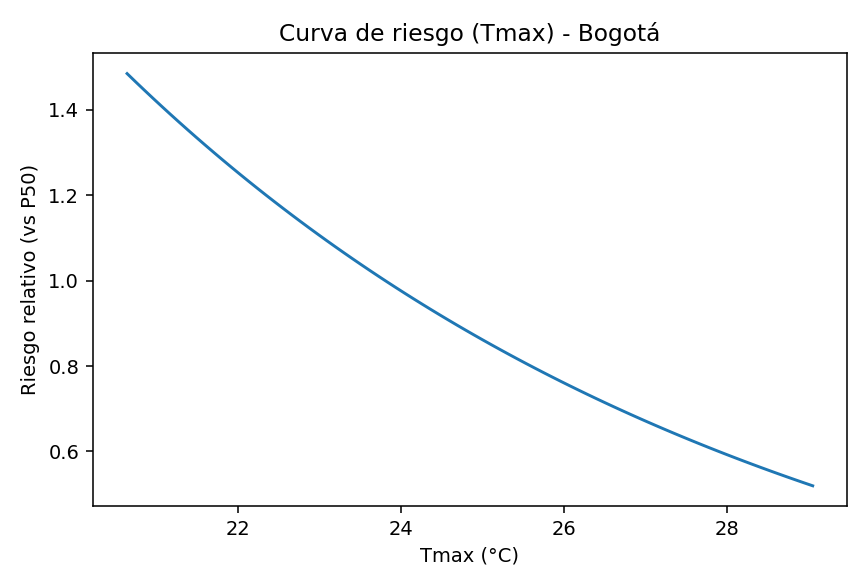

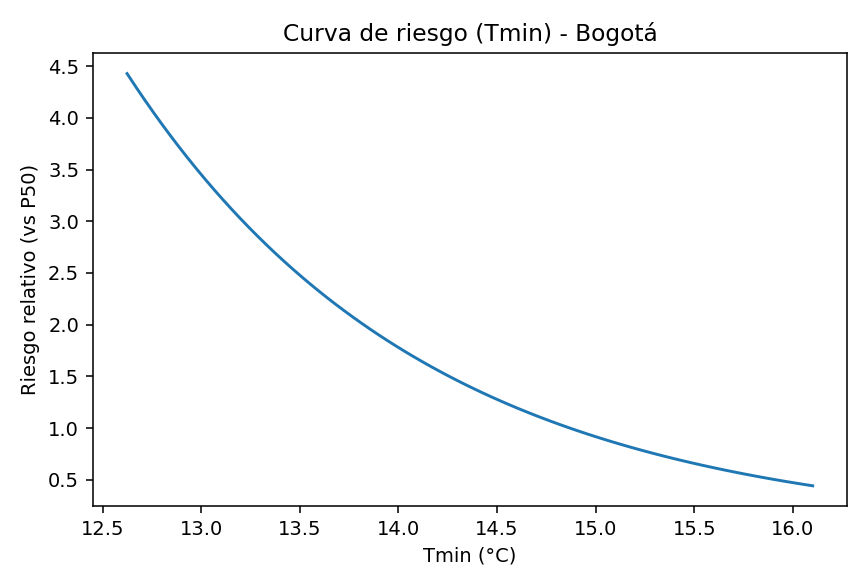

In [53]:
# === Rehacer curvas de Bogotá en escala RR vs P50 ===
import os, glob, numpy as np
from IPython.display import display, Image

# 0) Flags
USE_NB = False  # cámbialo a True si ya definiste fit_city_negbin y quieres NB

# 1) Chequeos
assert 'df' in globals(), "No existe 'df'. Ejecuta antes la unión (item 6)."
assert 'plot_risk_curve' in globals(), "No encuentro 'plot_risk_curve'. Usa la versión nueva que grafica RR vs P50."
RESULTS_DIR = globals().get('RESULTS_DIR', 'resultados_objetivo1')
os.makedirs(RESULTS_DIR, exist_ok=True)

# 2) Limpia PNGs antiguos de Bogotá
for p in glob.glob(os.path.join(RESULTS_DIR, "curva_riesgo_*_Bogota*.png")):
    try: os.remove(p)
    except: pass

# 3) Subconjunto Bogotá
g_bog = df[df.city=="Bogotá"].dropna(subset=["tmax","tmin","cvd_deaths"]).copy()
assert len(g_bog)>0, "No hay filas para 'Bogotá' con tmax/tmin/cvd_deaths no nulos."

# 4) Ajusta modelo (Poisson o NegBin)
if USE_NB:
    assert 'fit_city_negbin' in globals(), "Activa primero la celda 8B.1 para definir fit_city_negbin."
    res_bog, Xc_bog, disp_bog, meta_bog, alpha_bog = fit_city_negbin(g_bog)
    print(f"[Bogotá] NegBin OK | alpha={alpha_bog:.3f} | dispersión={disp_bog:.2f} | df(Tmax)={meta_bog['df_tmax_used']} df(Tmin)={meta_bog['df_tmin_used']}")
else:
    assert 'fit_city_poisson' in globals(), "No encuentro 'fit_city_poisson'."
    res_bog, Xc_bog, disp_bog, meta_bog = fit_city_poisson(g_bog)
    print(f"[Bogotá] Poisson OK | dispersión={disp_bog:.2f} | df(Tmax)={meta_bog['df_tmax_used']} df(Tmin)={meta_bog['df_tmin_used']}")

# 5) Prueba de sanidad: RR(P50 vs P50) ≈ 1
def _rr_ref(meta, res, g):
    t50M = float(np.nanmedian(g["tmax"]))
    t50m = float(np.nanmedian(g["tmin"]))
    trend_ref = float(np.nanmedian(g["trend"]))
    Xref = make_Xnew_from_meta(meta, t50M, t50m, trend_ref).values
    mu_ref = float(np.exp(Xref @ np.asarray(res.params).reshape(-1,1)))
    return mu_ref

mu_ref = _rr_ref(meta_bog, res_bog, g_bog)
print(f"[Check] μ(P50,P50)={mu_ref:.6f} → al graficar dividimos por μ_ref, por eso RR(P50)=1.")

# 6) Re-grafica en RR
plot_risk_curve(g_bog, res_bog, meta_bog, var="tmax", fname="curva_riesgo_tmax_Bogota.png")
plot_risk_curve(g_bog, res_bog, meta_bog, var="tmin", fname="curva_riesgo_tmin_Bogota.png")

# 7) Muestra PNGs
for fn in ["curva_riesgo_tmax_Bogota.png", "curva_riesgo_tmin_Bogota.png"]:
    path = os.path.join(RESULTS_DIR, fn)
    if os.path.exists(path):
        display(Image(filename=path))
    else:
        print(f"⚠️ No se encontró {path}.")


In [54]:
# ===== 8B.3 — EMPAQUE Y DESCARGA =====
import shutil, os
zip_nb = "resultados_nb_obj1.zip"
if os.path.exists(zip_nb):
    os.remove(zip_nb)
shutil.make_archive("resultados_nb_obj1", "zip", RESULTS_DIR)

from google.colab import files
files.download(zip_nb)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 9)Auditoría rápida

In [45]:
aud = (df
       .assign(is_valid = df[["tmax","tmin","cvd_deaths"]].notna().all(axis=1))
       .groupby("city")
       .agg(
           filas_total   = ("date","size"),
           filas_validas = ("is_valid","sum"),
           dias_unicos   = ("date", "nunique"),
           tmax_unicos   = ("tmax", lambda s: s.dropna().nunique()),
           tmin_unicos   = ("tmin", lambda s: s.dropna().nunique()),
       )
       .reset_index())
display(aud)


,city,filas_total,filas_validas,dias_unicos,tmax_unicos,tmin_unicos
0,Barranquilla,120,120,120,104,97
1,Bogotá,27,27,27,27,26
2,Cali,120,120,120,111,108
3,Medellín,120,120,120,109,98


# Objetivo específico 1 — Exploración de temperaturas (2010–2019)
**Propósito:** caracterizar los **patrones temporales** de temperatura **máxima (Tmax)** y **mínima (Tmin)** por ciudad (Bogotá, Medellín, Cali y Barranquilla), e identificar **extremos** (P95 y P05) y su **variación temporal** como insumo para el Objetivo 2.

**Entregables de esta sección (sin RR):**
- Series diarias y suavizadas de **Tmax/Tmin** por ciudad.
- **Climatología mensual** (promedios 2010–2019) con bandas de variabilidad.
- **Conteo anual de días extremos** (calor P95, frío P05).
- **Distribuciones** con cuantiles (P05/P50/P95) y **mapas de anomalías** (día-del-año × año).
- Tablas de verificación de **rango temporal** por ciudad.


In [58]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from unidecode import unidecode

plt.rcParams["figure.dpi"] = 140
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

RESULTS_DIR = "resultados_obj1_intro"
os.makedirs(RESULTS_DIR, exist_ok=True)


In [60]:
from google.colab import files
uploaded = files.upload()
list(uploaded.keys())


Saving Base_diaria_MORT (1).xlsx to Base_diaria_MORT (1) (3).xlsx
Saving POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST CALI.csv to POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST CALI (3).csv
Saving POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST MAX Y MIN CALI.csv to POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST MAX Y MIN CALI (3).csv
Saving POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST (1) MAX Y MIN BOGOTÁ.csv to POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST (1) MAX Y MIN BOGOTÁ (3).csv
Saving POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST BOGOTA.csv to POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST BOGOTA (3).csv
Saving POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MAX Y MIN MEDELLIN.csv to POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MAX Y MIN MEDELLIN (3).csv
Saving POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MEDELLIN.csv to POWER_Point_Daily_20100101_20201231_006d25N_075d58W

['Base_diaria_MORT (1) (3).xlsx',
 'POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST CALI (3).csv',
 'POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST MAX Y MIN CALI (3).csv',
 'POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST (1) MAX Y MIN BOGOTÁ (3).csv',
 'POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST BOGOTA (3).csv',
 'POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MAX Y MIN MEDELLIN (3).csv',
 'POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MEDELLIN (3).csv',
 'POWER_Point_Daily_20100101_20201231_010d96N_074d80W_LST BARRANQUILLA (3).csv',
 'POWER_Point_Daily_20100101_20201231_010d96N_074d80W_LST MAX Y MIN BARRANQUILLA (3).csv']

In [64]:
# === LECTOR ROBUSTO NASA POWER V2 ===
import os, io, re
import numpy as np
import pandas as pd
from unidecode import unidecode

CITY_MAP = {
    "bogota": "Bogotá", "bogotá": "Bogotá",
    "medellin": "Medellín", "medellín": "Medellín",
    "cali": "Cali",
    "barranquilla": "Barranquilla",
}

def _norm(s: str) -> str:
    """Normaliza nombres: mayúsculas, sin acentos, sin espacios/guiones/puntos."""
    return re.sub(r'[^A-Z0-9]', '', unidecode(str(s)).upper())

def _guess_city_from_name(fname: str) -> str:
    s = unidecode(os.path.basename(fname)).lower()
    for k, v in CITY_MAP.items():
        if k in s:
            return v
    return "Ciudad"

def _find_header_line(lines):
    """
    Busca la línea con los nombres de columnas. POWER suele escribir metadatos antes.
    """
    for i, line in enumerate(lines[:120]):  # mira más líneas por si el header aparece tarde
        U = _norm(line)
        if any(tok in U for tok in ["YEAR", "DATE", "YYYYMMDD", "DOY", "JDAY"]) and (line.count(",")+line.count(";")+line.count("\t") >= 2):
            return i
    # Fallback: primera línea con muchos separadores
    for i, line in enumerate(lines[:120]):
        if line.count(",") >= 3 or line.count(";") >= 3 or line.count("\t") >= 3:
            return i
    return 0

def _pick_delim(header_line: str) -> str:
    counts = {",": header_line.count(","), ";": header_line.count(";"), "\t": header_line.count("\t")}
    return max(counts, key=counts.get)  # el más frecuente

def _read_csv_from_header(fname: str):
    with open(fname, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    h = _find_header_line(lines)
    sep = _pick_delim(lines[h])
    df = pd.read_csv(io.StringIO("".join(lines[h:])), sep=sep, engine="python")
    # Limpia encabezados
    df.columns = [c.strip() for c in df.columns]
    return df, h, sep

def _pick_date_columns(df: pd.DataFrame) -> pd.Series:
    """Devuelve una Serie datetime construida desde varias posibilidades."""
    # Mapa normalizado -> original
    U = {_norm(c): c for c in df.columns}

    # 1) YYYYMMDD / FECHA compacta
    for key in list(U.keys()):
        if key in ["YYYYMMDD", "FECHA", "DATE", "DATETIME", "ISODATE", "LOCALDATE"]:
            s = pd.to_datetime(df[U[key]], errors="coerce")
            if s.notna().mean() > 0.8:
                return s
        # También si la serie parece 8 dígitos
        col = U[key]
        try:
            as_str = df[col].astype(str).str.replace(r"\D", "", regex=True)
            if (as_str.str.len()==8).mean() > 0.8:
                s = pd.to_datetime(as_str, format="%Y%m%d", errors="coerce")
                if s.notna().mean() > 0.8:
                    return s
        except Exception:
            pass

    # 2) YEAR + MO(MON/MONTH/MES) + DY(DAY/DIA)
    YEAR_CANDS  = ["YEAR","YR","YYYY","ANO","ANIO","AÑO"]
    MONTH_CANDS = ["MO","MON","MONTH","MES","MM"]
    DAY_CANDS   = ["DY","DAY","DIA","DD"]
    def _find_one(cands):
        for key in U:
            if any(c == key or c in key for c in cands):
                return U[key]
        return None
    ycol = _find_one(YEAR_CANDS)
    mcol = _find_one(MONTH_CANDS)
    dcol = _find_one(DAY_CANDS)
    if ycol is not None and mcol is not None and dcol is not None:
        y = pd.to_numeric(df[ycol], errors="coerce")
        m = pd.to_numeric(df[mcol], errors="coerce")
        d = pd.to_numeric(df[dcol], errors="coerce")
        s = pd.to_datetime(dict(year=y, month=m, day=d), errors="coerce")
        if s.notna().mean() > 0.8:
            return s

    # 3) YEAR + DOY/JDAY/JULIAN
    DOY_CANDS = ["DOY","JDAY","JULIAN","DAYOFYEAR"]
    doycol = _find_one(DOY_CANDS)
    if ycol is not None and doycol is not None:
        y = pd.to_numeric(df[ycol], errors="coerce").astype("Int64")
        j = pd.to_numeric(df[doycol], errors="coerce").astype("Int64")
        combo = y.astype(str).str.zfill(4) + j.astype(str).str.zfill(3)
        s = pd.to_datetime(combo, format="%Y%j", errors="coerce")
        if s.notna().mean() > 0.8:
            return s

    raise ValueError("No pude construir la fecha (no hallé YEAR/MONTH/DAY ni DATE/FECHA ni YEAR+DOY/Julian).")

def _is_num(s: pd.Series) -> bool:
    x = pd.to_numeric(s, errors="coerce")
    return x.notna().mean() > 0.9

def _pick_t_columns(df: pd.DataFrame):
    """Elige columnas de Tmax/Tmin entre múltiples alias."""
    cols = list(df.columns)
    N = [_norm(c) for c in cols]

    pairs = [
        (["T2MMAX"], ["T2MMIN"]),
        (["TMAX"], ["TMIN"]),
        (["LSTMAX"], ["LSTMIN"]),
        (["LSTDAY","LSTDAY1KM","LSTDAYKM"], ["LSTNIGHT","LSTNIGHT1KM","LSTNIGHTKM"]),
        (["LSTDAY"], ["LSTNIGHT"]),
        (["TMAX2M"], ["TMIN2M"]),
    ]
    # Búsqueda por prioridad
    for lefts, rights in pairs:
        tmax = [cols[i] for i, n in enumerate(N) if any(p in n for p in lefts) and _is_num(df[cols[i]])]
        tmin = [cols[i] for i, n in enumerate(N) if any(p in n for p in rights) and _is_num(df[cols[i]])]
        if tmax and tmin:
            return tmax[0], tmin[0]

    # Heurística MAX/MIN genérica
    tmax = [cols[i] for i, n in enumerate(N) if "MAX" in n and _is_num(df[cols[i]])]
    tmin = [cols[i] for i, n in enumerate(N) if "MIN" in n and _is_num(df[cols[i]])]
    if tmax and tmin:
        return tmax[0], tmin[0]

    # Day/Night como proxy
    tday  = [cols[i] for i, n in enumerate(N) if "DAY" in n and _is_num(df[cols[i]])]
    tnite = [cols[i] for i, n in enumerate(N) if "NIGHT" in n and _is_num(df[cols[i]])]
    if tday and tnite:
        return tday[0], tnite[0]

    raise ValueError("No identifiqué columnas de Tmax/Tmin.")

def _read_one_power_csv(fname: str) -> pd.DataFrame:
    df, h, sep = _read_csv_from_header(fname)
    try:
        date = _pick_date_columns(df)
    except Exception as e:
        # Depuración: imprime cabezales para ayudarte a ver nombres
        print(f"[DEBUG] Columnas en {os.path.basename(fname)}:", list(df.columns)[:20])
        raise

    # columnas t
    tmax_col, tmin_col = _pick_t_columns(df)

    out = pd.DataFrame({
        "date": pd.to_datetime(date, errors="coerce"),
        "tmax": pd.to_numeric(df[tmax_col], errors="coerce"),
        "tmin": pd.to_numeric(df[tmin_col], errors="coerce"),
    }).dropna(subset=["date"])

    city = _guess_city_from_name(fname)
    out["city"]  = city
    out["year"]  = out["date"].dt.year
    out["month"] = out["date"].dt.month
    out["doy"]   = out["date"].dt.dayofyear
    out["ym"]    = out["date"].dt.to_period("M").dt.to_timestamp()

    print(f"[OK] {os.path.basename(fname)} | header@{h} sep='{sep}' | cols Tmax/Tmin: {tmax_col} / {tmin_col} | filas={len(out)}")
    return out

def _leer_temperaturas_desde_subida(uploaded_dict):
    csvs = [n for n in uploaded_dict.keys() if n.lower().endswith(".csv")]
    if not csvs:
        raise ValueError("No subiste CSV. Usa files.upload() con tus archivos POWER.")

    frames = []
    for fn in csvs:
        try:
            frames.append(_read_one_power_csv(fn))
        except Exception as e:
            print(f"[AVISO] {fn}: {e}")

    if not frames:
        raise ValueError("No pude leer ningún CSV. Revisa el [DEBUG] de columnas para ajustar patrones.")

    temps = pd.concat(frames, ignore_index=True)
    temps = (temps.sort_values(["city","date"])
                  .groupby(["city","date"], as_index=False)
                  .agg(tmax=("tmax","mean"), tmin=("tmin","mean"),
                       year=("year","first"), month=("month","first"),
                       doy=("doy","first"), ym=("ym","first")))

    # Extremos por ciudad (P95/P05) — opcional para sombrear en gráficas
    temps["heat_extreme"] = False
    temps["cold_extreme"] = False
    for c, g in temps.groupby("city"):
        p95 = np.nanpercentile(g["tmax"], 95)
        p05 = np.nanpercentile(g["tmin"], 5)
        idx = g.index
        temps.loc[idx, "heat_extreme"] = g["tmax"] >= p95
        temps.loc[idx, "cold_extreme"] = g["tmin"] <= p05

    print("Ciudades:", sorted(temps["city"].unique()))
    print(temps.groupby("city")["date"].agg(["min","max","size"]))
    return temps

# === Ejecutar ===
temps = _leer_temperaturas_desde_subida(uploaded)


[AVISO] POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST CALI (3).csv: No identifiqué columnas de Tmax/Tmin.
[OK] POWER_Point_Daily_20100101_20201231_003d45N_076d52W_LST MAX Y MIN CALI (3).csv | header@10 sep=',' | cols Tmax/Tmin: T2M_MAX / T2M_MIN | filas=4018
[OK] POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST (1) MAX Y MIN BOGOTÁ (3).csv | header@10 sep=',' | cols Tmax/Tmin: T2M_MAX / T2M_MIN | filas=4018
[DEBUG] Columnas en POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST BOGOTA (3).csv: ['Dates (month/day/year): 01/01/2010 through 12/31/2020 in LST', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
[AVISO] POWER_Point_Daily_20100101_20201231_004d61N_074d07W_LST BOGOTA (3).csv: No pude construir la fecha (no hallé YEAR/MONTH/DAY ni DATE/FECHA ni YEAR+DOY/Julian).
[OK] POWER_Point_Daily_20100101_20201231_006d25N_075d58W_LST MAX Y MIN MEDELLIN (3).csv | header@10 sep=',' | cols Tmax/Tmin: T2M_MAX / T2M_MIN | filas=4018
[AVISO] POWER_Point_Daily_20100101_

In [65]:
def _fname(city, base):
    c = unidecode(city).replace(" ", "_")
    return os.path.join(RESULTS_DIR, f"{base}_{c}.png")

def plot_series_suavizadas(g, city, window=30):
    g = g.sort_values("date").copy()
    g["tmax_roll"] = g["tmax"].rolling(window, min_periods=5, center=True).mean()
    g["tmin_roll"] = g["tmin"].rolling(window, min_periods=5, center=True).mean()

    fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
    ax[0].plot(g["date"], g["tmax"], lw=0.4, alpha=0.5, label="Tmax diaria")
    ax[0].plot(g["date"], g["tmax_roll"], lw=1.5, label=f"Tmax {window}d suave")
    if "heat_extreme" in g.columns:
        ax[0].fill_between(g["date"], ax[0].get_ylim()[0], ax[0].get_ylim()[1],
                           where=g["heat_extreme"].astype(bool), color="tab:red", alpha=0.08,
                           transform=ax[0].get_xaxis_transform(), label="Día P95 (calor)")
    ax[0].set_title(f"{city} — Tmax diaria y suavizada")
    ax[0].set_ylabel("°C"); ax[0].legend(ncol=3)

    ax[1].plot(g["date"], g["tmin"], lw=0.4, alpha=0.5, label="Tmin diaria")
    ax[1].plot(g["date"], g["tmin_roll"], lw=1.5, label=f"Tmin {window}d suave")
    if "cold_extreme" in g.columns:
        ax[1].fill_between(g["date"], ax[1].get_ylim()[0], ax[1].get_ylim()[1],
                           where=g["cold_extreme"].astype(bool), color="tab:blue", alpha=0.08,
                           transform=ax[1].get_xaxis_transform(), label="Día P05 (frío)")
    ax[1].set_title(f"{city} — Tmin diaria y suavizada")
    ax[1].set_xlabel("Fecha"); ax[1].set_ylabel("°C"); ax[1].legend(ncol=3)

    plt.tight_layout()
    out = _fname(city, "serie_diaria_suavizada")
    plt.savefig(out, dpi=150); plt.show()
    print("[PNG]", out)

def plot_climatologia_mensual(g, city):
    clim = (g.groupby("month")
              .agg(tmax_m=("tmax","mean"), tmin_m=("tmin","mean"),
                   tmax_p10=("tmax", lambda x: np.nanpercentile(x,10)),
                   tmax_p90=("tmax", lambda x: np.nanpercentile(x,90)),
                   tmin_p10=("tmin", lambda x: np.nanpercentile(x,10)),
                   tmin_p90=("tmin", lambda x: np.nanpercentile(x,90)))
              .reset_index())

    fig, ax = plt.subplots(1,2, figsize=(11,4))
    ax[0].plot(clim["month"], clim["tmax_m"], lw=2, label="Tmax media")
    ax[0].fill_between(clim["month"], clim["tmax_p10"], clim["tmax_p90"], alpha=0.2, label="P10–P90")
    ax[0].set_title(f"{city} — Climatología mensual Tmax"); ax[0].set_xlabel("Mes"); ax[0].set_ylabel("°C"); ax[0].legend()

    ax[1].plot(clim["month"], clim["tmin_m"], lw=2, label="Tmin media")
    ax[1].fill_between(clim["month"], clim["tmin_p10"], clim["tmin_p90"], alpha=0.2, label="P10–P90")
    ax[1].set_title(f"{city} — Climatología mensual Tmin"); ax[1].set_xlabel("Mes"); ax[1].set_ylabel("°C"); ax[1].legend()

    plt.tight_layout()
    out = _fname(city, "climatologia_mensual")
    plt.savefig(out, dpi=150); plt.show()
    print("[PNG]", out)

def plot_extremos_por_anio(g, city):
    if not {"heat_extreme","cold_extreme"}.issubset(g.columns):
        print(f"[{city}] No hay columnas heat_extreme/cold_extreme; omito barras de extremos.")
        return
    an = (g.groupby("year")
            .agg(heat=("heat_extreme","sum"), cold=("cold_extreme","sum"))
            .reset_index())
    fig, ax = plt.subplots(1,2, figsize=(11,3.8), sharey=True)
    ax[0].bar(an["year"], an["heat"], width=0.8); ax[0].set_title(f"{city} — días de calor extremo (P95)")
    ax[0].set_xlabel("Año"); ax[0].set_ylabel("días")
    ax[1].bar(an["year"], an["cold"], width=0.8, color="tab:blue"); ax[1].set_title(f"{city} — días de frío extremo (P05)")
    ax[1].set_xlabel("Año")
    plt.tight_layout()
    out = _fname(city, "extremos_por_anio")
    plt.savefig(out, dpi=150); plt.show()
    print("[PNG]", out)

def plot_distribuciones(g, city):
    tmx = g["tmax"].dropna().values; tmn = g["tmin"].dropna().values
    qMx = np.nanpercentile(tmx, [5,50,95]); qMn = np.nanpercentile(tmn, [5,50,95])

    fig, ax = plt.subplots(1,2, figsize=(11,3.8))
    ax[0].hist(tmx, bins=30, alpha=0.6);
    for q,lab in zip(qMx, ["P05","P50","P95"]):
        ax[0].axvline(q, ls="--"); ax[0].text(q, ax[0].get_ylim()[1]*0.9, lab)
    ax[0].set_title(f"{city} — Distribución Tmax"); ax[0].set_xlabel("°C"); ax[0].set_ylabel("Frecuencia")

    ax[1].hist(tmn, bins=30, alpha=0.6, color="tab:orange")
    for q,lab in zip(qMn, ["P05","P50","P95"]):
        ax[1].axvline(q, ls="--"); ax[1].text(q, ax[1].get_ylim()[1]*0.9, lab)
    ax[1].set_title(f"{city} — Distribución Tmin"); ax[1].set_xlabel("°C")

    plt.tight_layout()
    out = _fname(city, "distribuciones")
    plt.savefig(out, dpi=150); plt.show()
    print("[PNG]", out)

def plot_mapa_anomalias(g, city, var="tmax"):
    base = (g.groupby("doy")[var].mean()).rolling(15, center=True, min_periods=5).mean()
    gg = g.copy()
    gg["anom"] = gg[var] - gg["doy"].map(base)
    pivot = gg.pivot(index="year", columns="doy", values="anom")
    vmax = np.nanpercentile(np.abs(gg["anom"]), 95)
    plt.figure(figsize=(11,3.8))
    im = plt.imshow(pivot, aspect="auto", cmap="coolwarm", vmin=-vmax, vmax=vmax)
    plt.colorbar(im, label="Anomalía (°C)")
    plt.title(f"{city} — Mapa de anomalías {var.upper()} (año × día-del-año)")
    plt.ylabel("Año"); plt.xlabel("Día del año")
    plt.tight_layout()
    out = _fname(city, f"anomalias_{var}")
    plt.savefig(out, dpi=150); plt.show()
    print("[PNG]", out)



=== Barranquilla ===


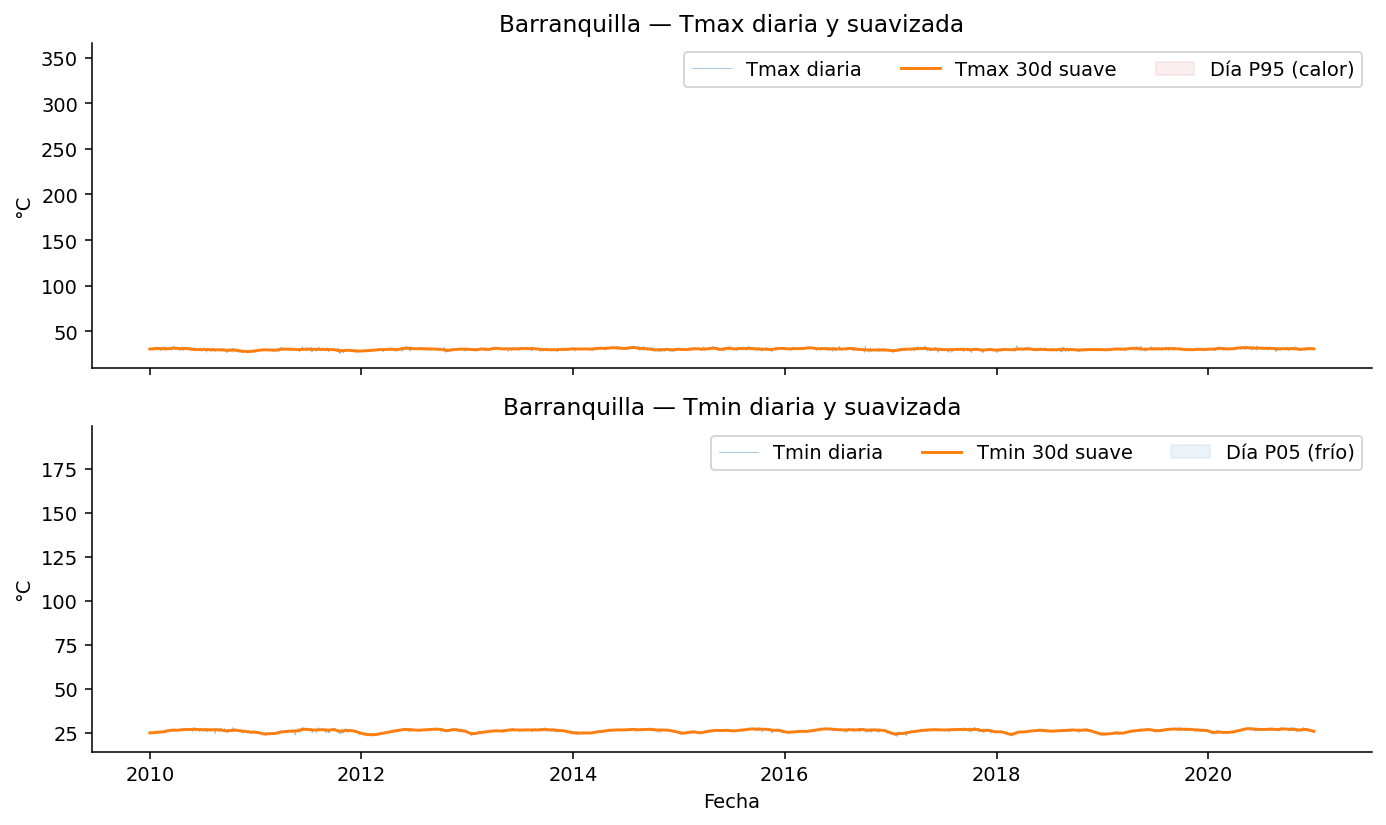

[PNG] resultados_obj1_intro/serie_diaria_suavizada_Barranquilla.png


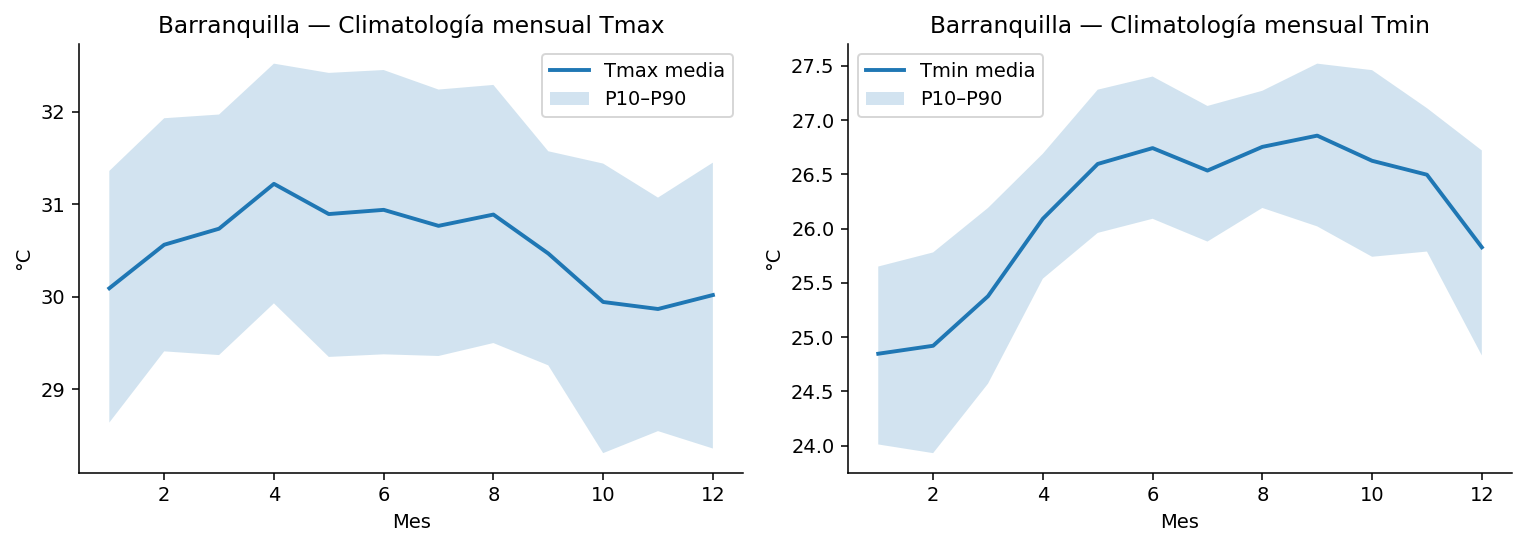

[PNG] resultados_obj1_intro/climatologia_mensual_Barranquilla.png


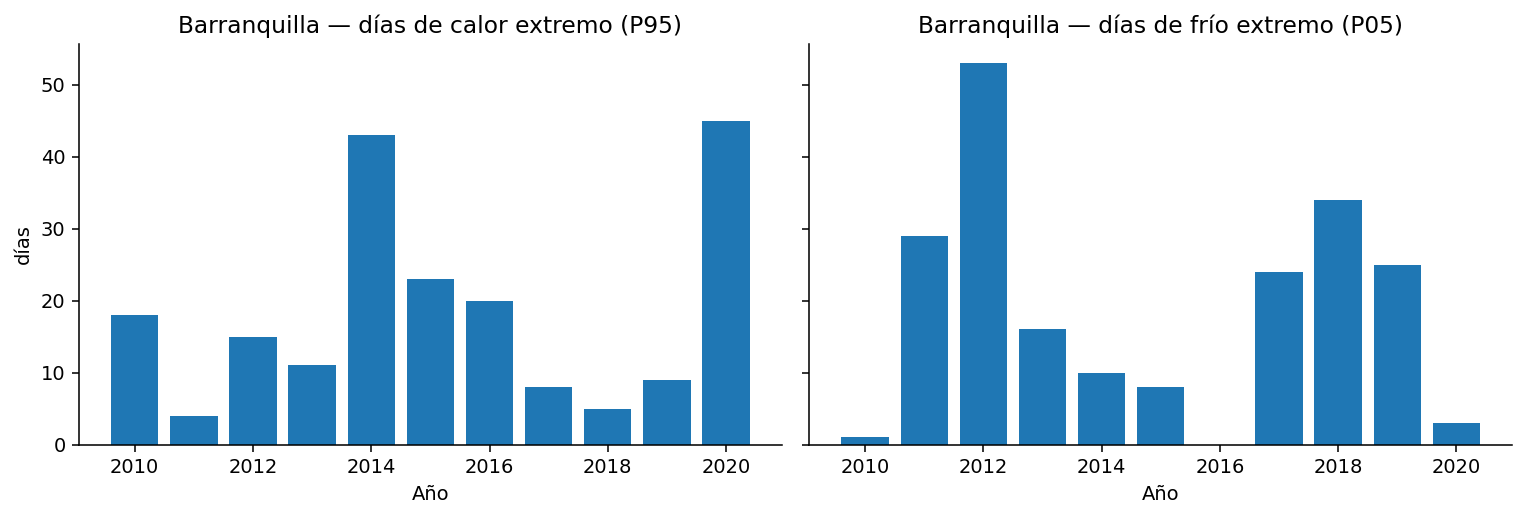

[PNG] resultados_obj1_intro/extremos_por_anio_Barranquilla.png


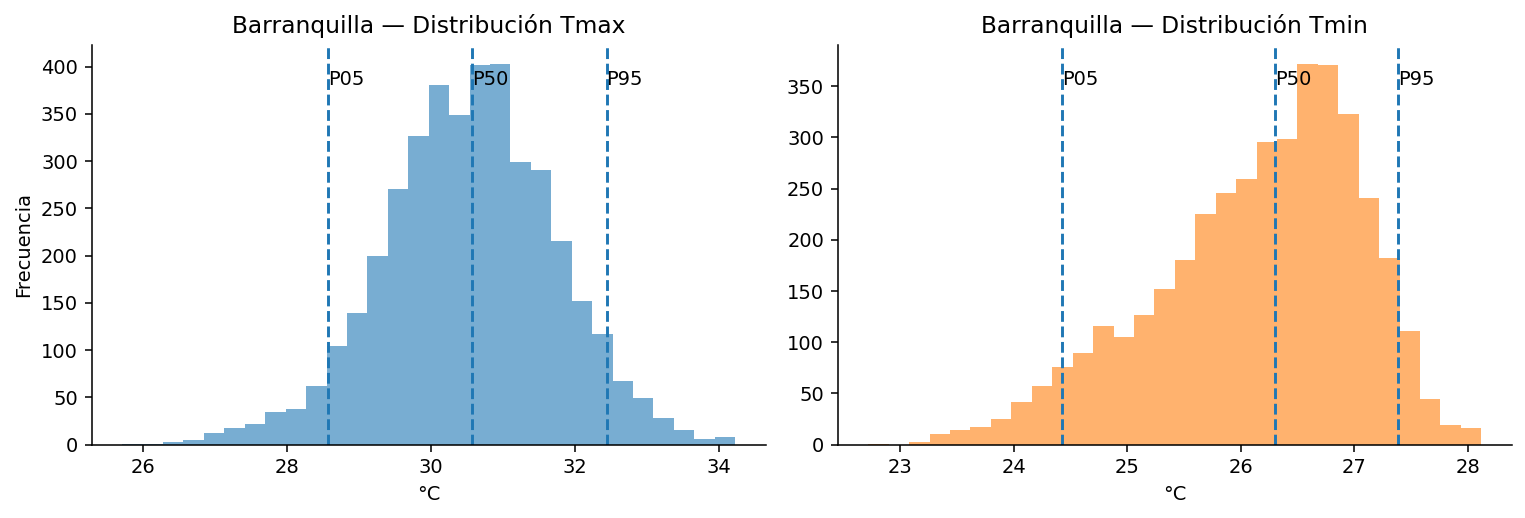

[PNG] resultados_obj1_intro/distribuciones_Barranquilla.png


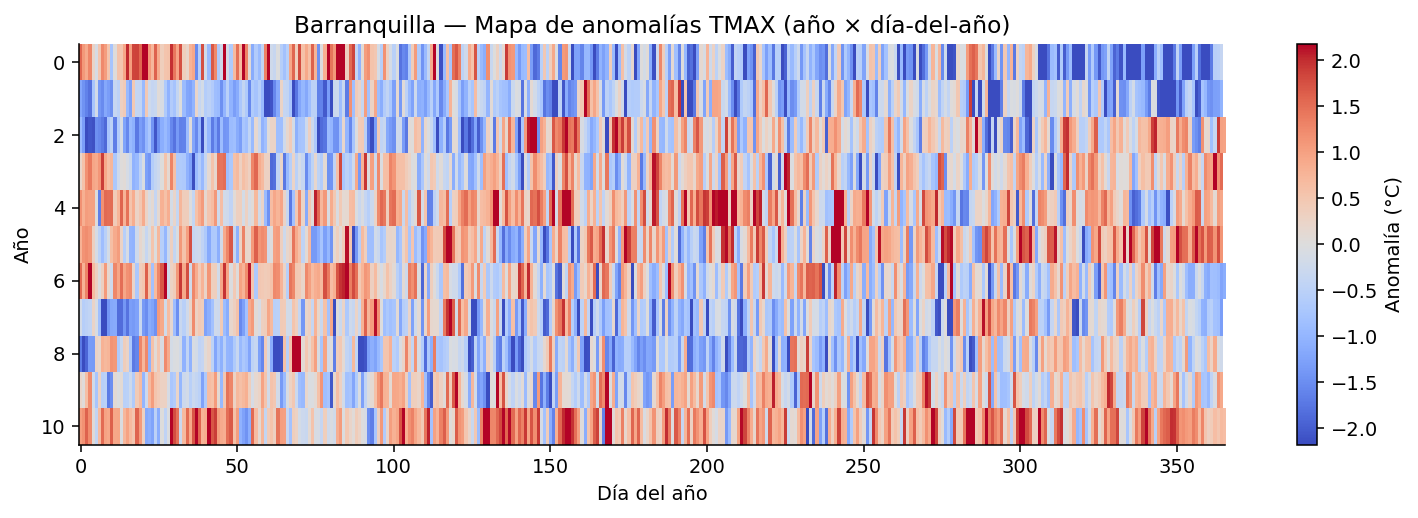

[PNG] resultados_obj1_intro/anomalias_tmax_Barranquilla.png


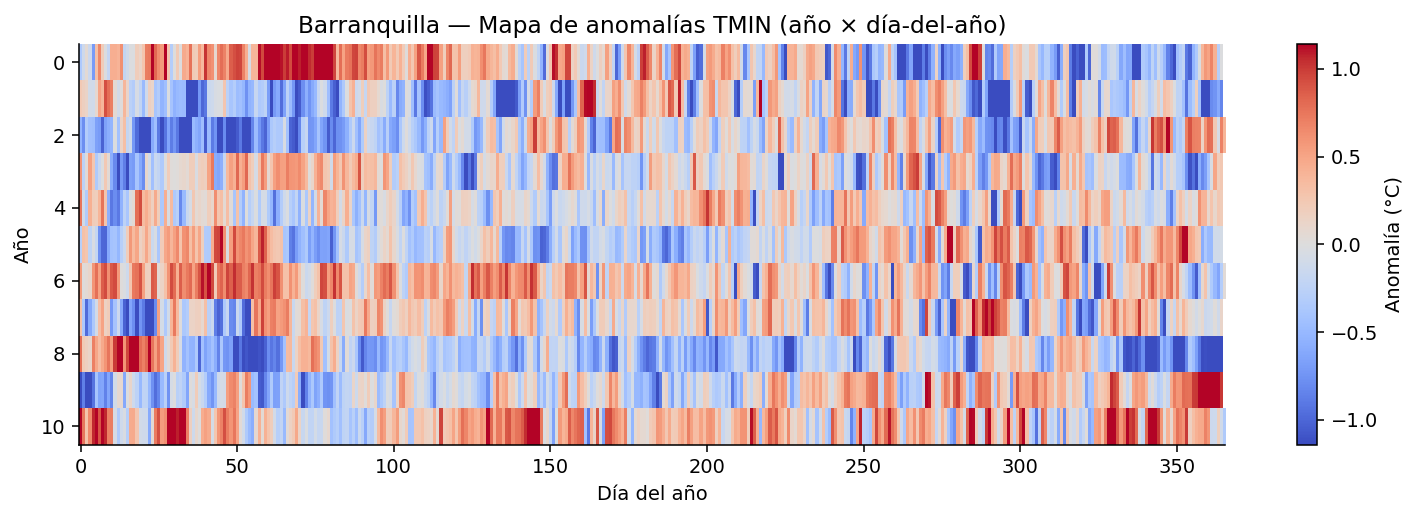

[PNG] resultados_obj1_intro/anomalias_tmin_Barranquilla.png

=== Bogotá ===


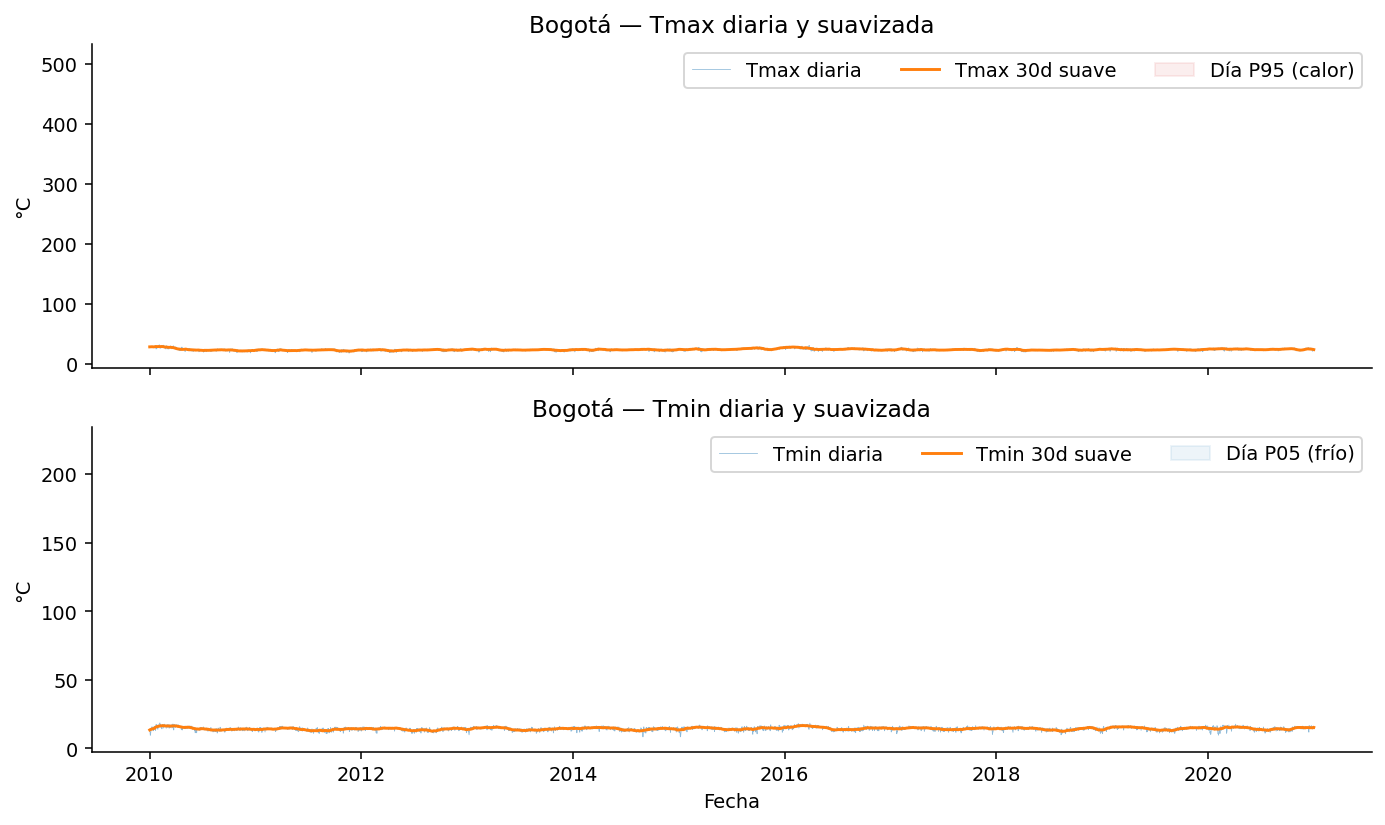

[PNG] resultados_obj1_intro/serie_diaria_suavizada_Bogota.png


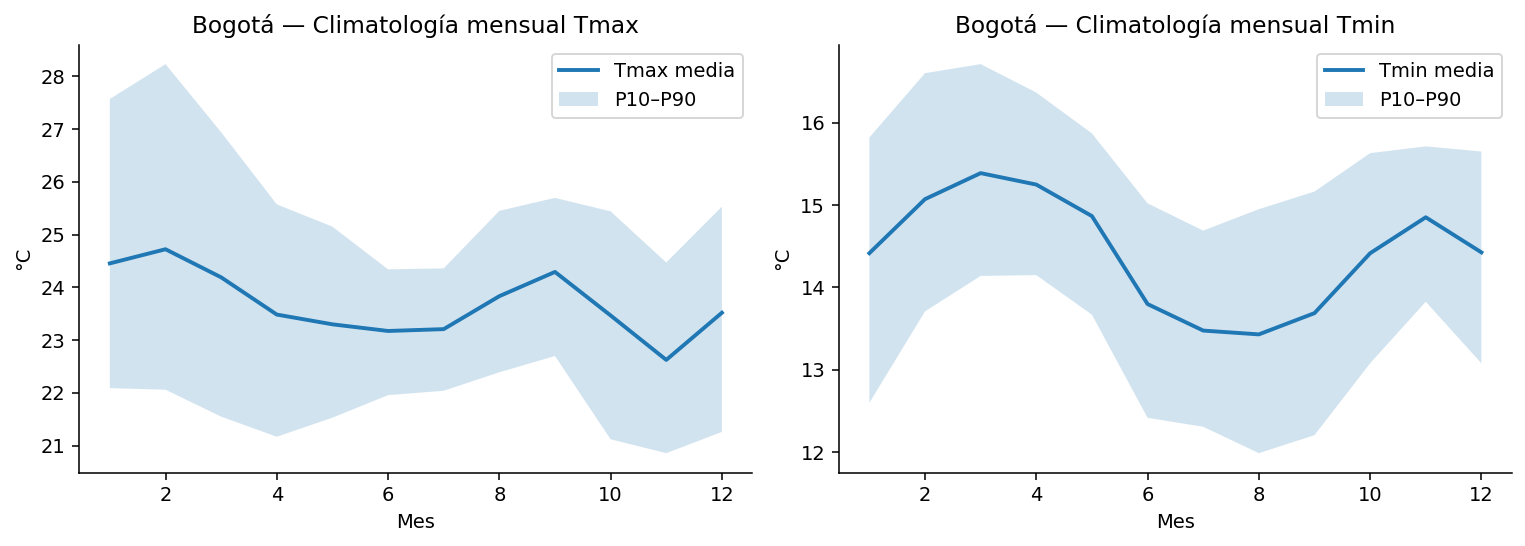

[PNG] resultados_obj1_intro/climatologia_mensual_Bogota.png


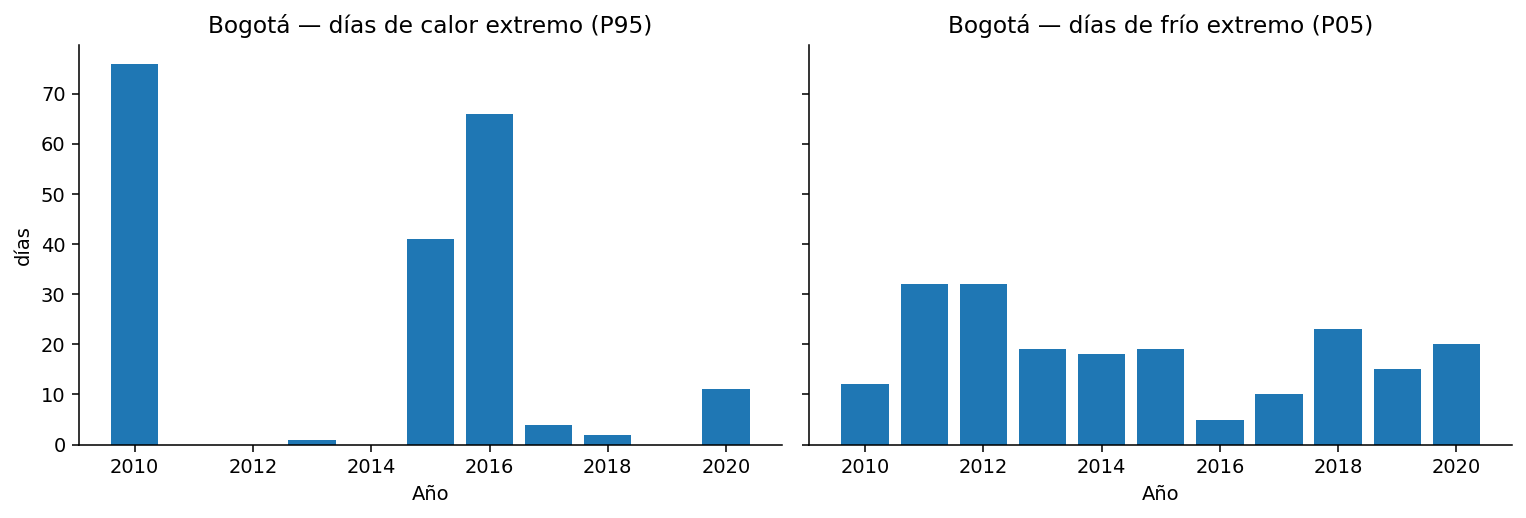

[PNG] resultados_obj1_intro/extremos_por_anio_Bogota.png


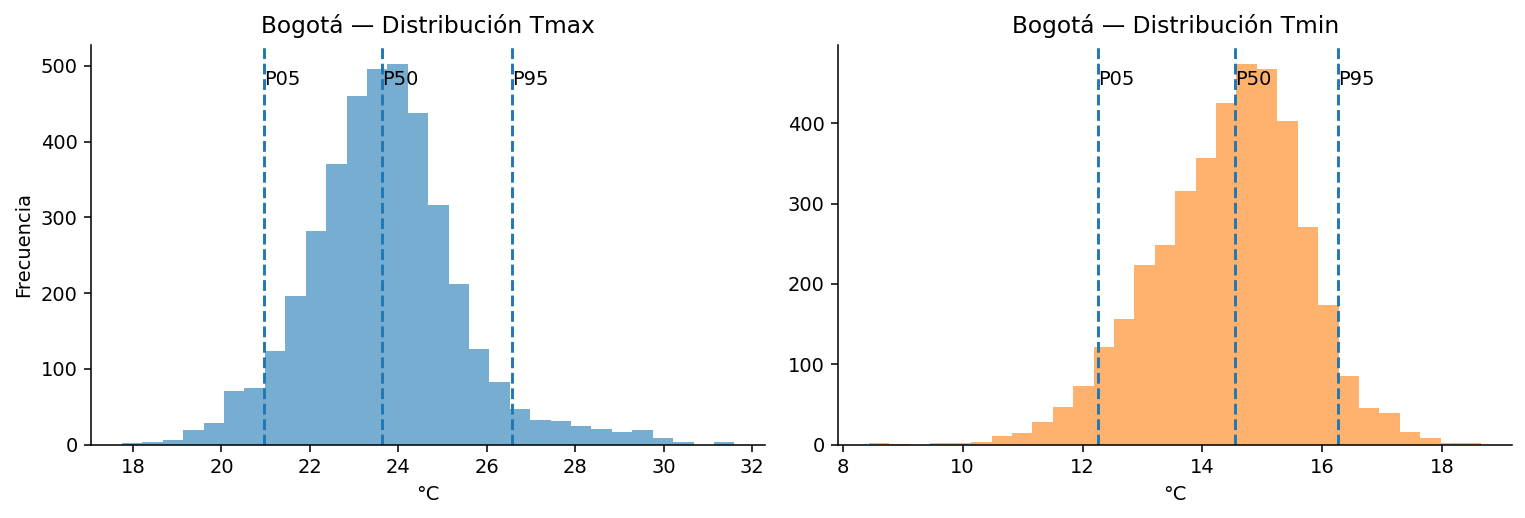

[PNG] resultados_obj1_intro/distribuciones_Bogota.png


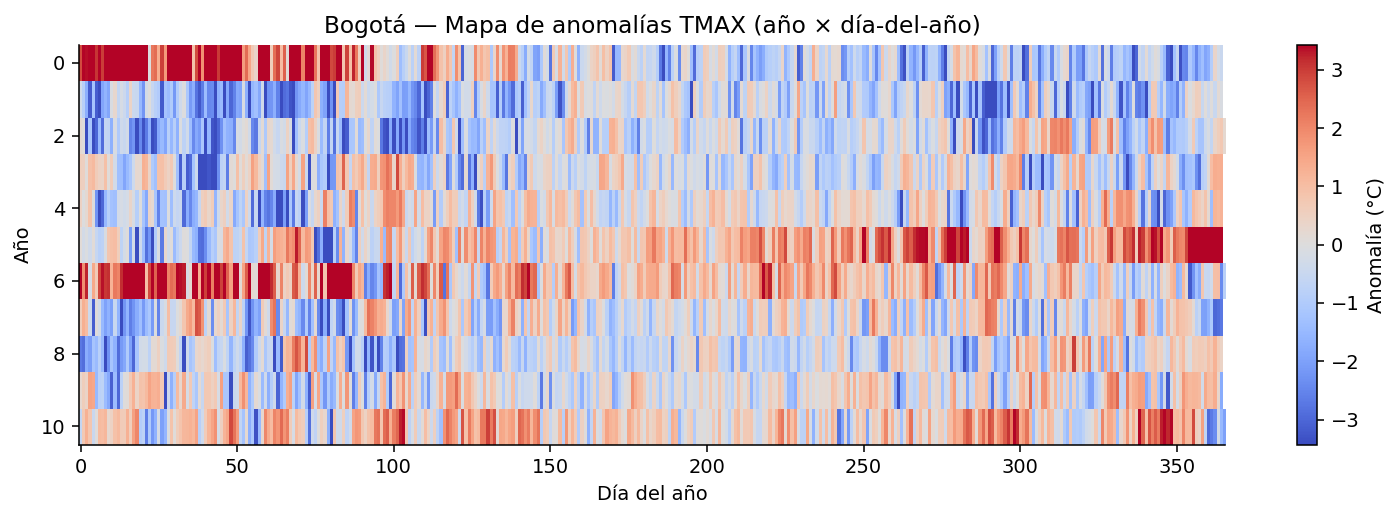

[PNG] resultados_obj1_intro/anomalias_tmax_Bogota.png


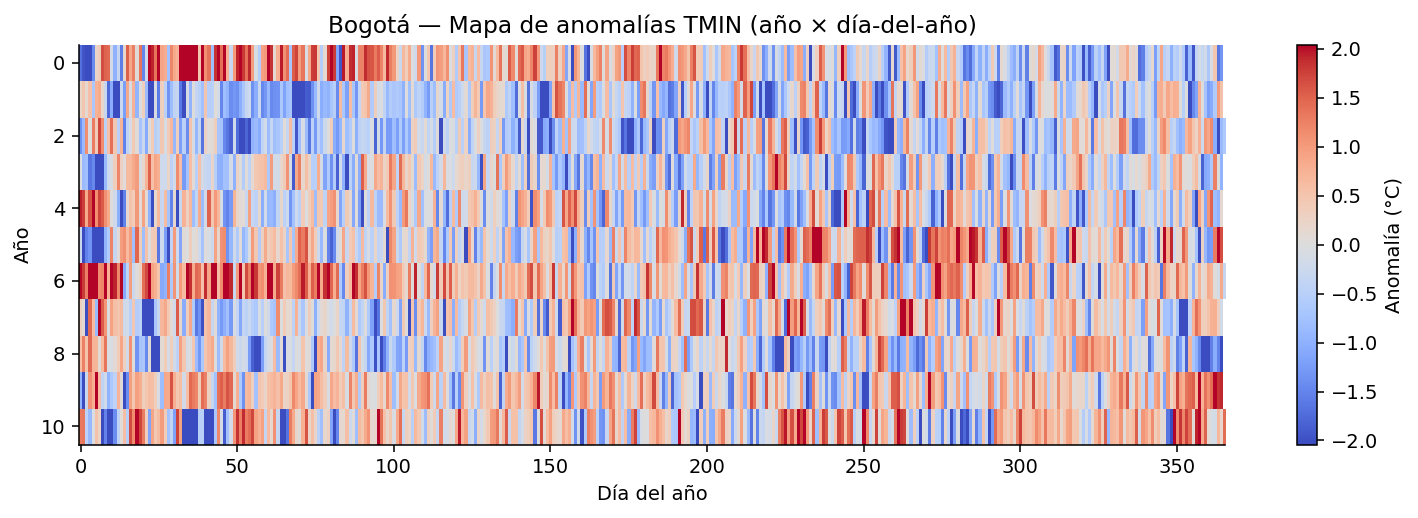

[PNG] resultados_obj1_intro/anomalias_tmin_Bogota.png

=== Cali ===


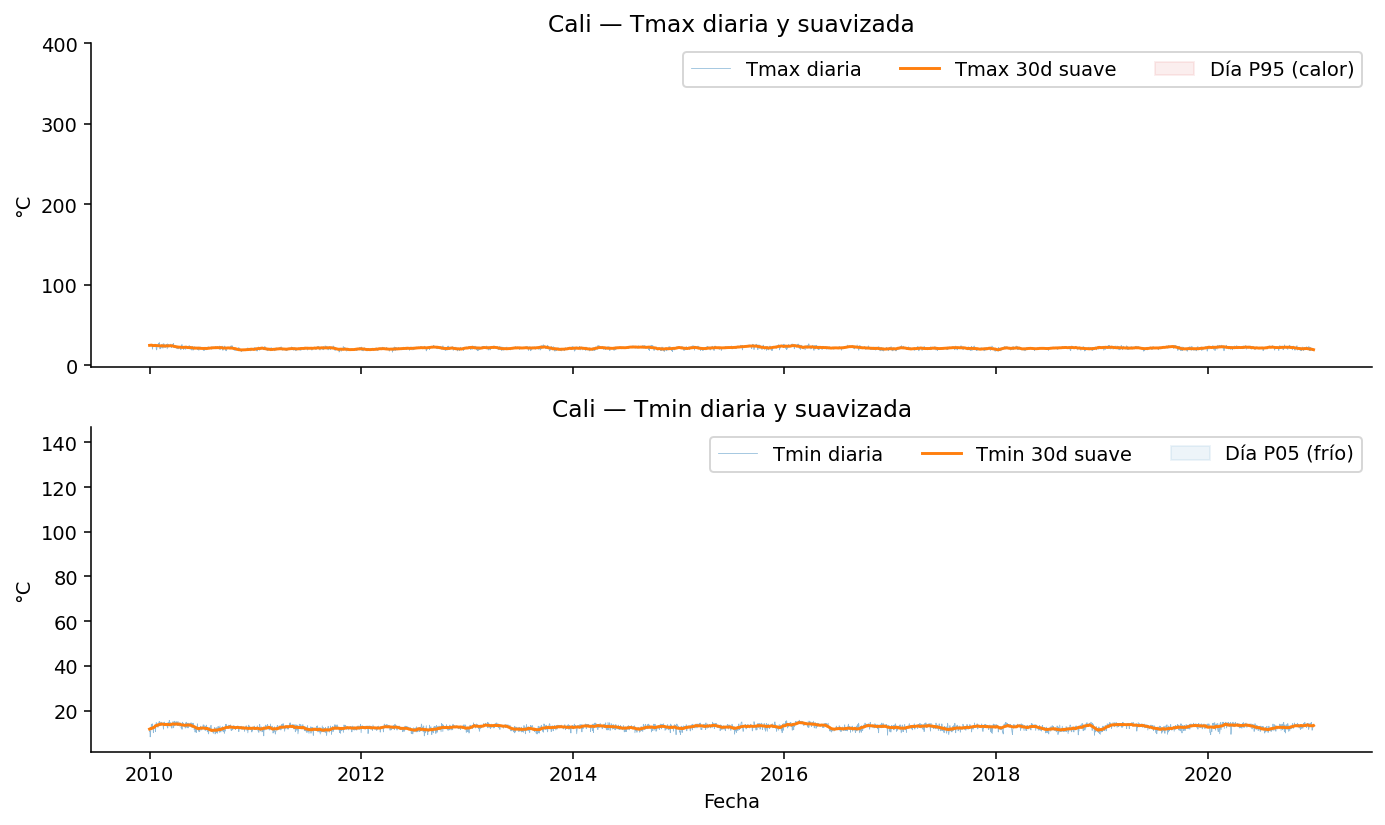

[PNG] resultados_obj1_intro/serie_diaria_suavizada_Cali.png


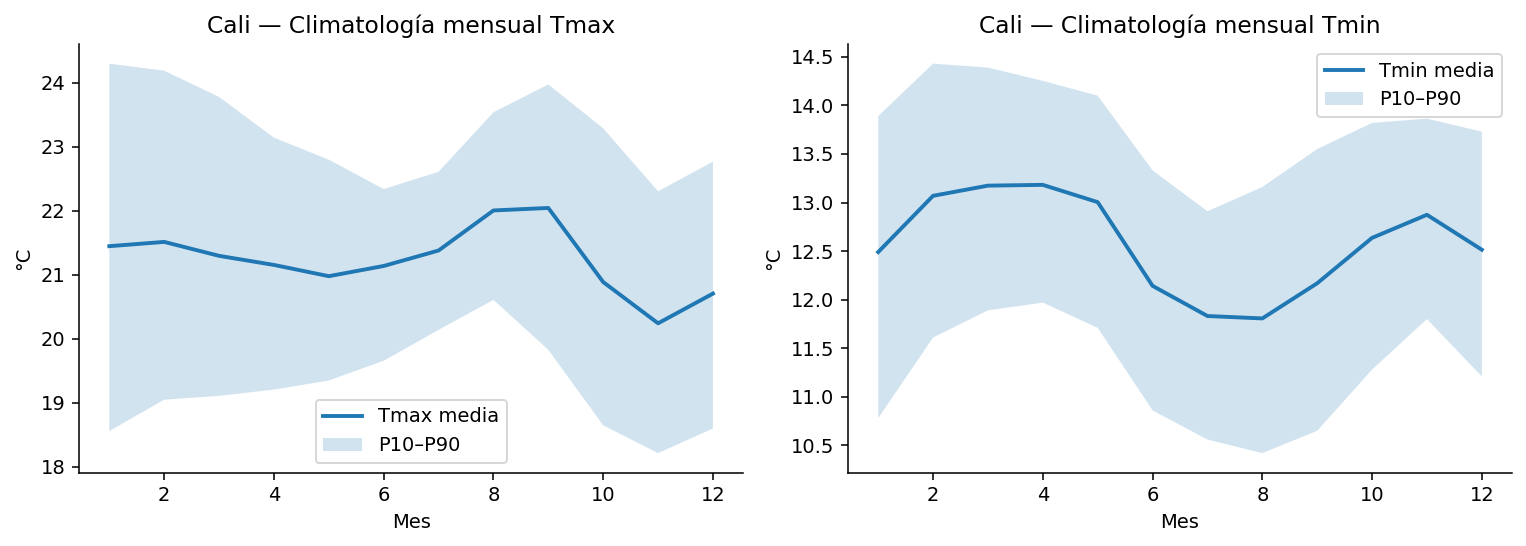

[PNG] resultados_obj1_intro/climatologia_mensual_Cali.png


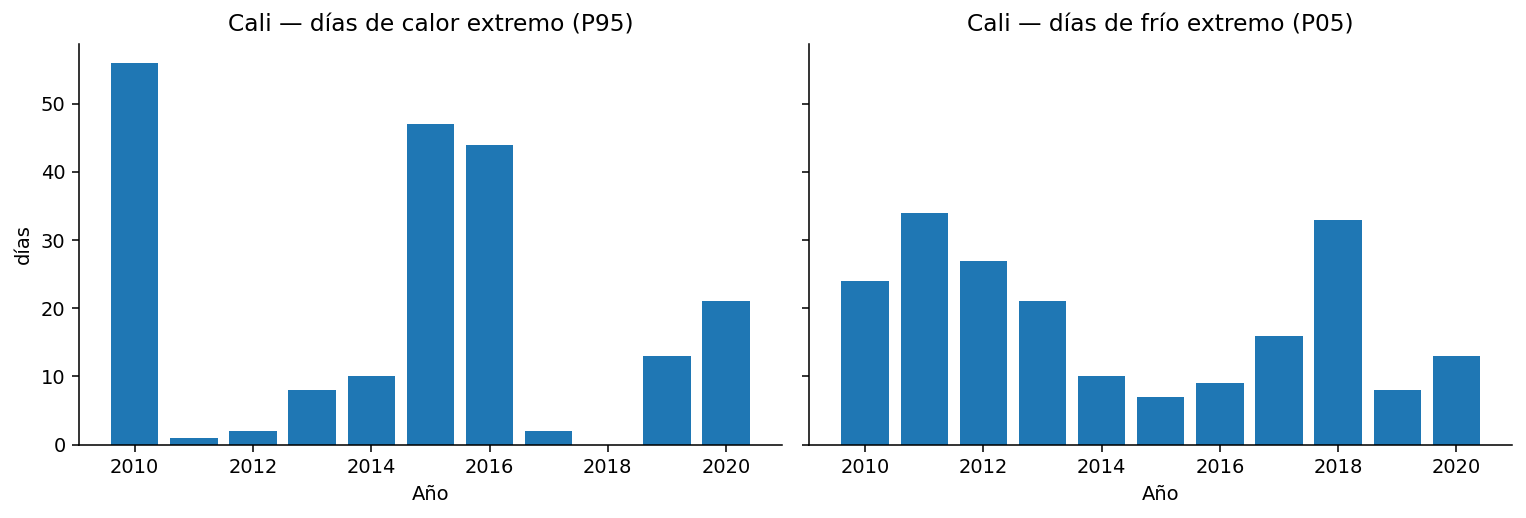

[PNG] resultados_obj1_intro/extremos_por_anio_Cali.png


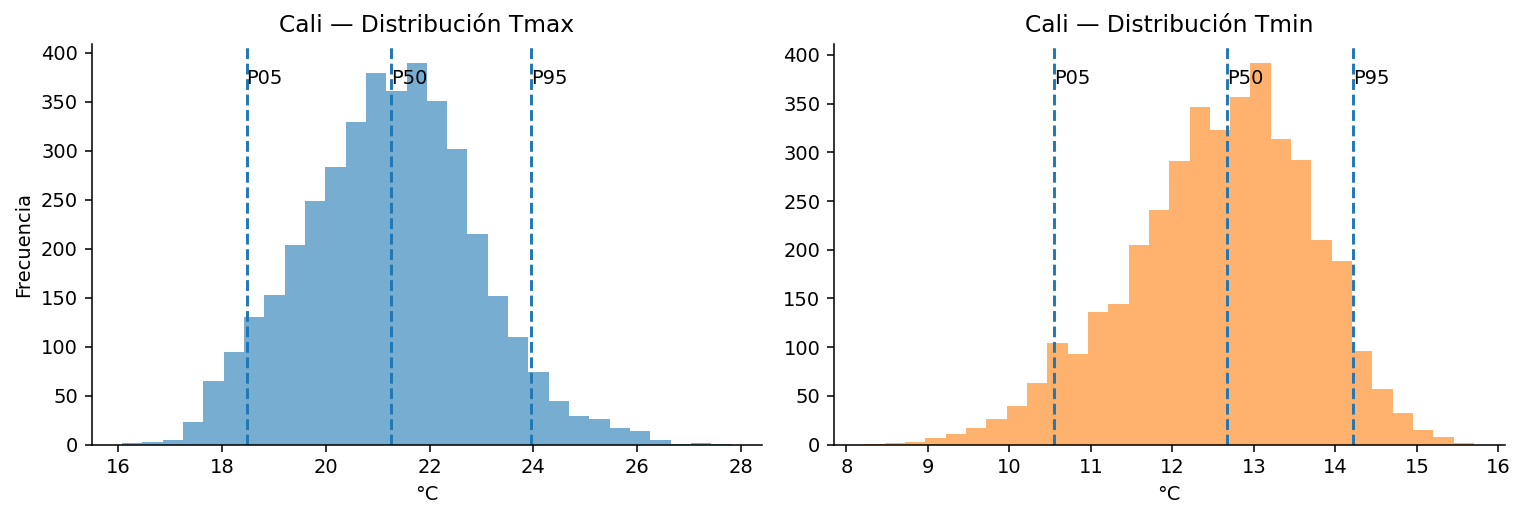

[PNG] resultados_obj1_intro/distribuciones_Cali.png


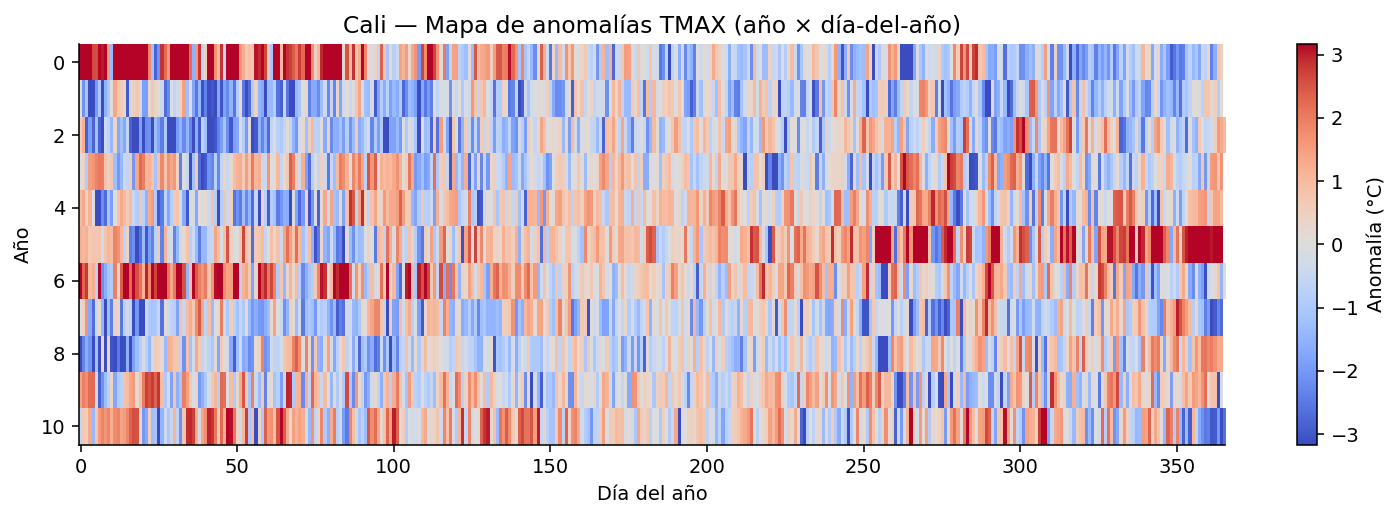

[PNG] resultados_obj1_intro/anomalias_tmax_Cali.png


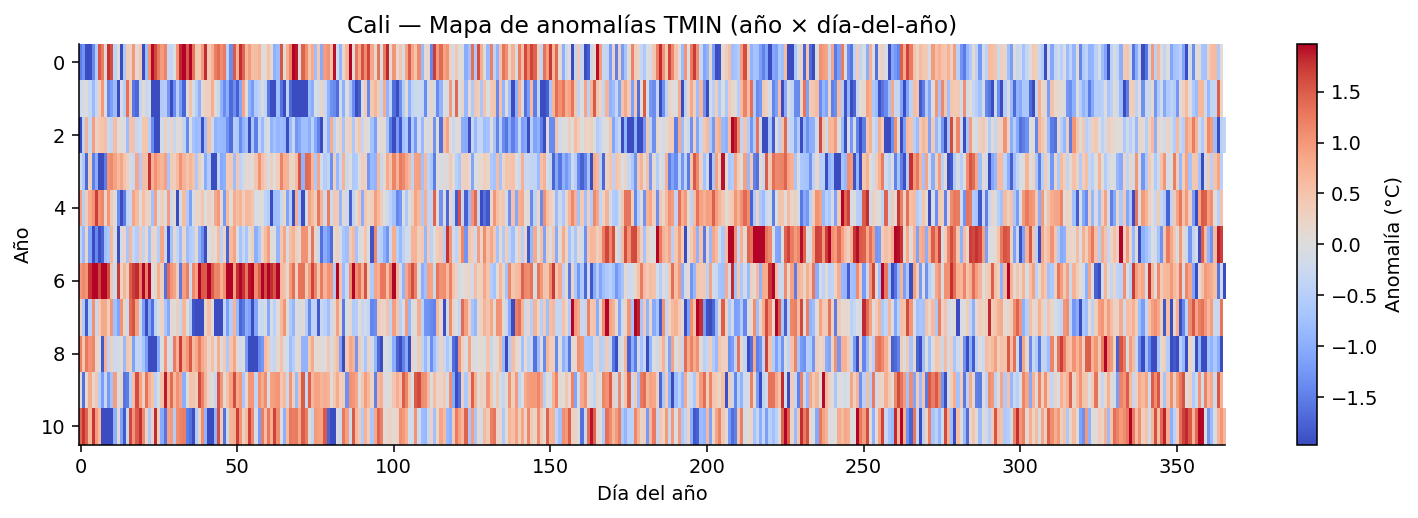

[PNG] resultados_obj1_intro/anomalias_tmin_Cali.png

=== Medellín ===


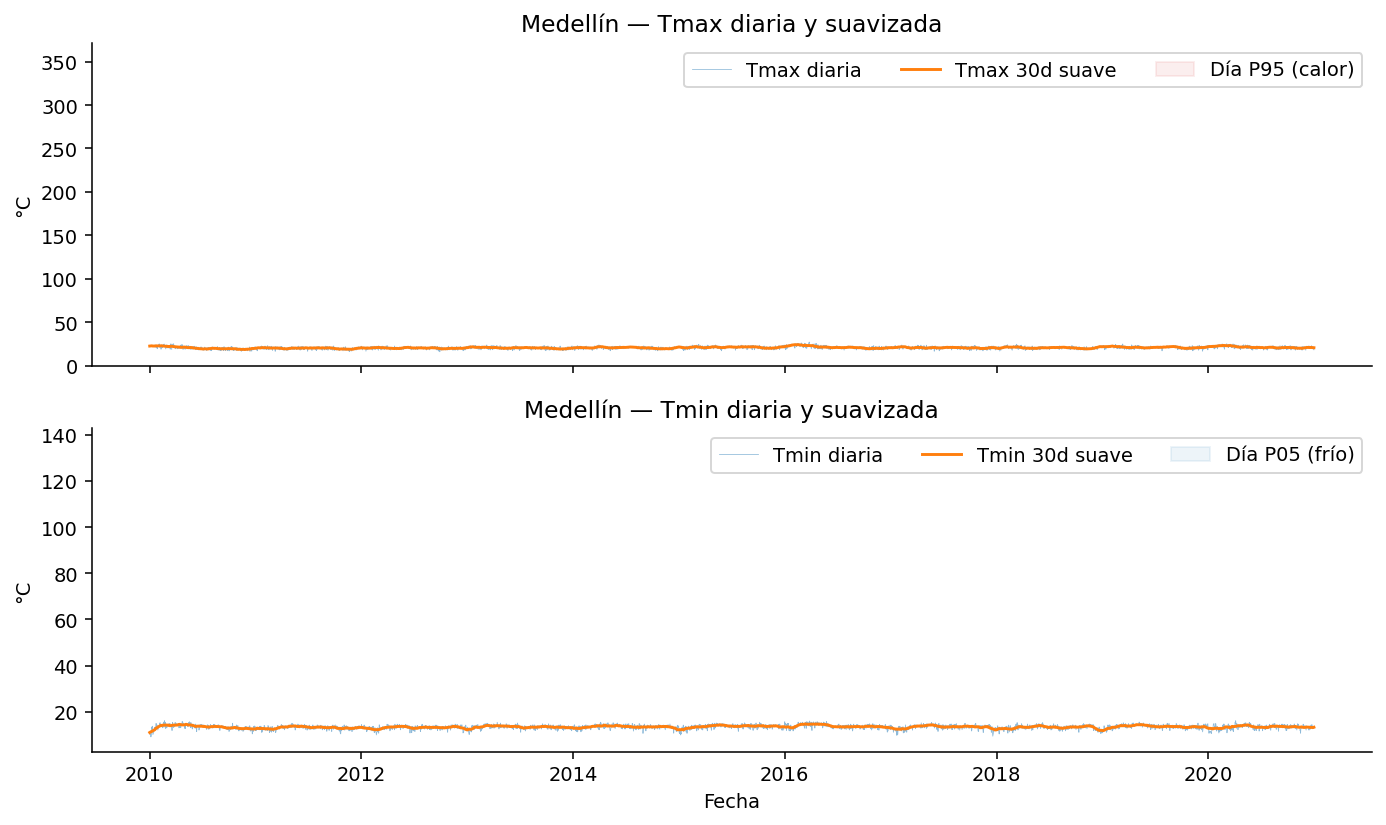

[PNG] resultados_obj1_intro/serie_diaria_suavizada_Medellin.png


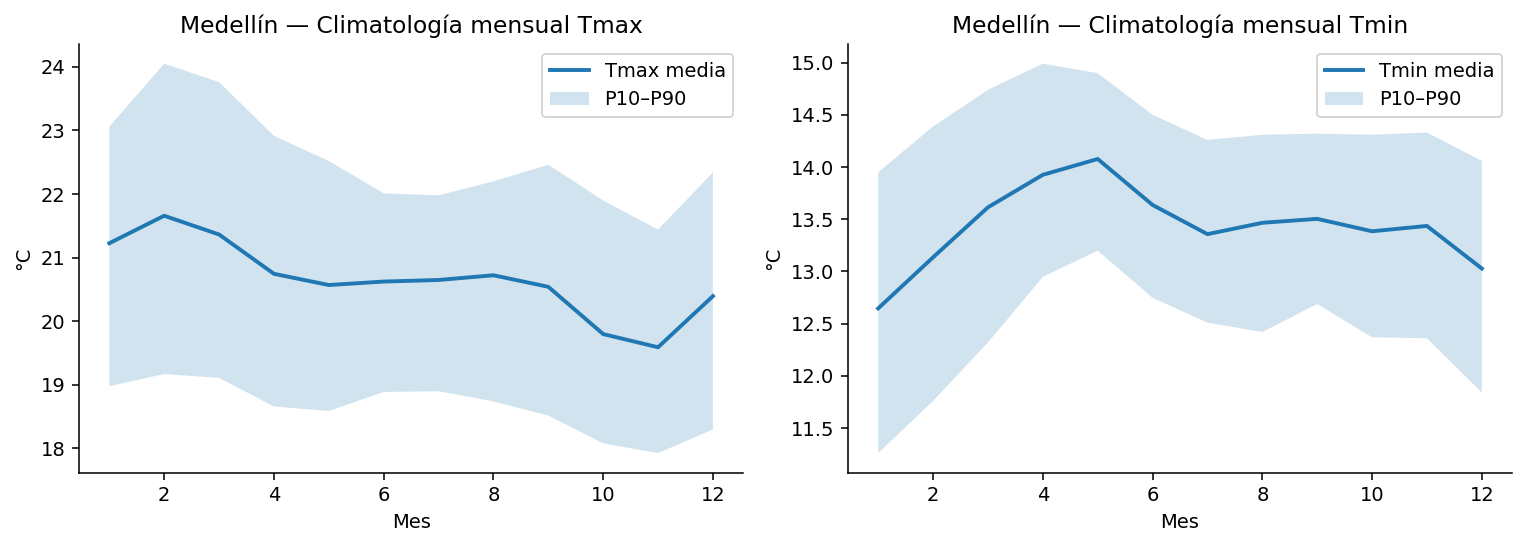

[PNG] resultados_obj1_intro/climatologia_mensual_Medellin.png


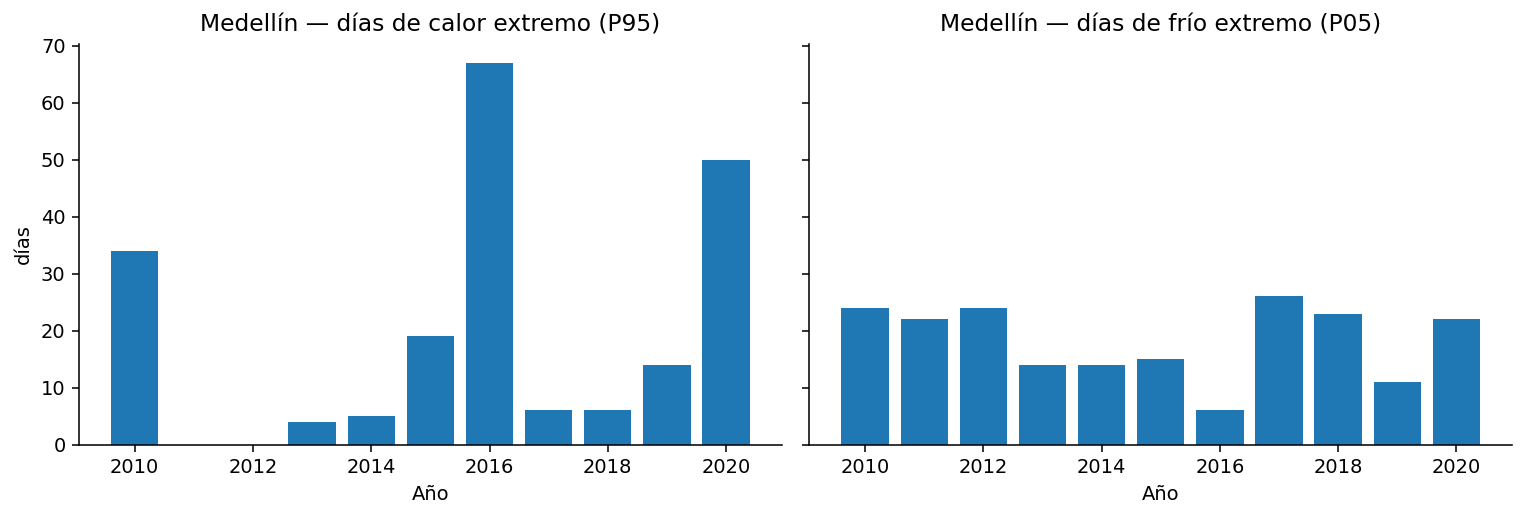

[PNG] resultados_obj1_intro/extremos_por_anio_Medellin.png


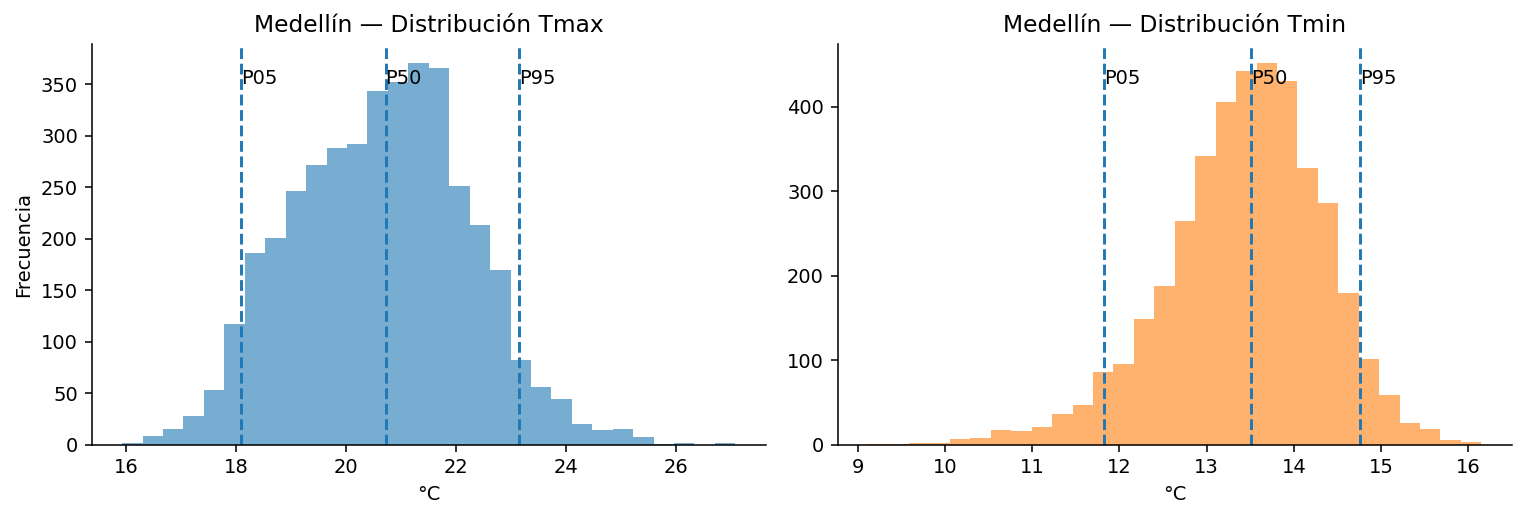

[PNG] resultados_obj1_intro/distribuciones_Medellin.png


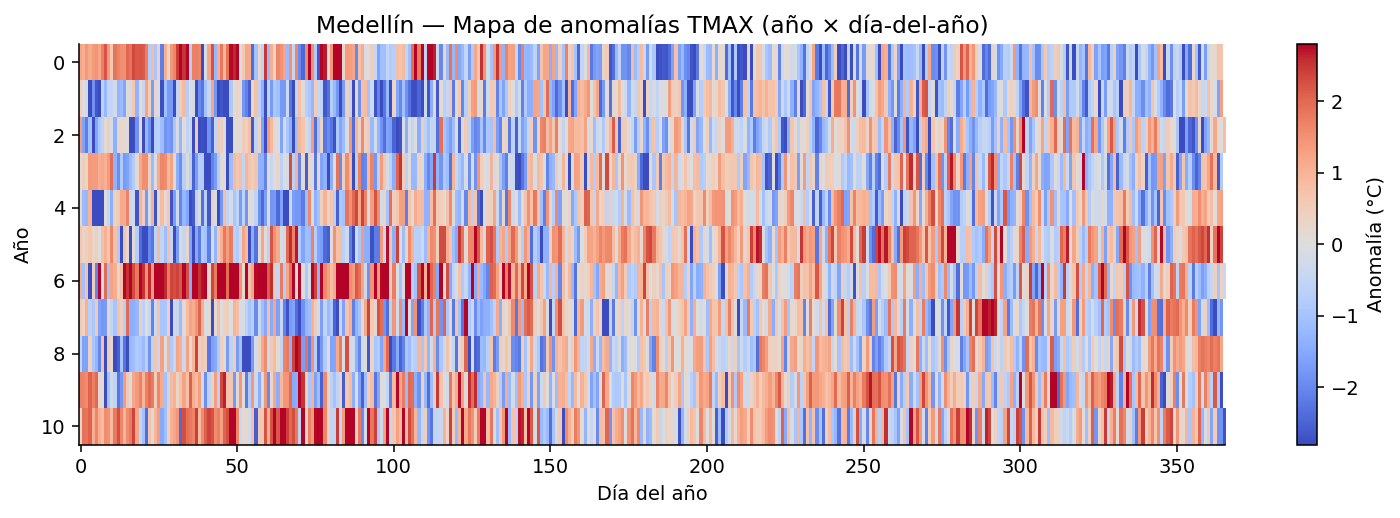

[PNG] resultados_obj1_intro/anomalias_tmax_Medellin.png


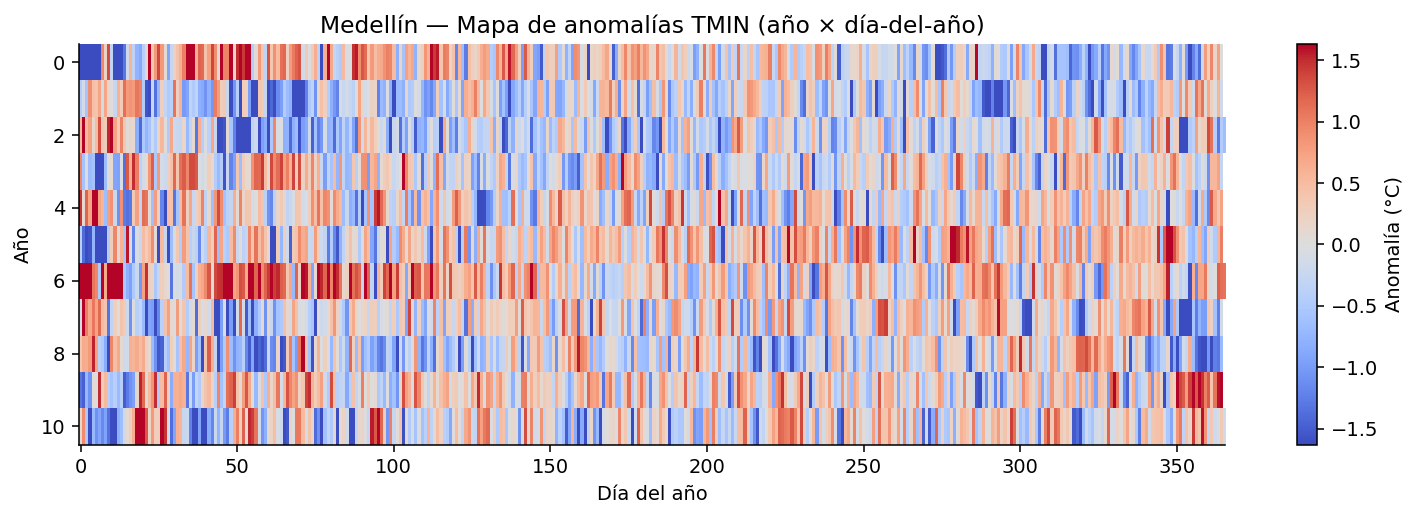

[PNG] resultados_obj1_intro/anomalias_tmin_Medellin.png


In [66]:
for city, g in temps.groupby("city"):
    print(f"\n=== {city} ===")
    g = g.sort_values("date").copy()
    plot_series_suavizadas(g, city, window=30)
    plot_climatologia_mensual(g, city)
    plot_extremos_por_anio(g, city)     # se dibuja solo si hay heat_extreme/cold_extreme
    plot_distribuciones(g, city)
    plot_mapa_anomalias(g, city, var="tmax")
    plot_mapa_anomalias(g, city, var="tmin")


In [67]:
if {"heat_extreme","cold_extreme"}.issubset(temps.columns):
    ext_summary = (temps.groupby("city")
                   .agg(heat_pct=("heat_extreme","mean"),
                        cold_pct=("cold_extreme","mean"))
                   .reset_index())
    ext_summary["heat_pct"] *= 100
    ext_summary["cold_pct"] *= 100
    ext_summary.round(2)


In [68]:
# ===== 8B.3 — EMPAQUE Y DESCARGA =====
import os, shutil

# 1) Detecta carpeta de resultados
if 'RESULTS_DIR' not in globals() or not os.path.isdir(RESULTS_DIR):
    # intenta algunas carpetas típicas usadas antes
    candidatos = ["resultados_nb_obj1", "resultados_objetivo1", "resultados_obj1_intro"]
    existentes = [d for d in candidatos if os.path.isdir(d)]
    if existentes:
        RESULTS_DIR = existentes[0]
        print(f"[INFO] RESULTS_DIR no definido; usando '{RESULTS_DIR}'")
    else:
        raise FileNotFoundError(
            "No encuentro carpeta de resultados. Define RESULTS_DIR o crea alguna de: "
            "resultados_nb_obj1, resultados_objetivo1, resultados_obj1_intro"
        )

# 2) Empaqueta a ZIP
zip_base = "resultados_nb_obj1"           # nombre base sin .zip
zip_nb   = f"{zip_base}.zip"              # archivo final .zip
if os.path.exists(zip_nb):
    os.remove(zip_nb)

# Crea el zip con todo el contenido de RESULTS_DIR
shutil.make_archive(zip_base, "zip", RESULTS_DIR)

# 3) Reporte rápido y descarga
zip_size_mb = os.path.getsize(zip_nb) / (1024*1024)
print(f"[OK] ZIP creado: {zip_nb} ({zip_size_mb:.2f} MB) desde '{RESULTS_DIR}'")

from google.colab import files
files.download(zip_nb)


[OK] ZIP creado: resultados_nb_obj1.zip (1.17 MB) desde 'resultados_obj1_intro'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>